Link to where I found the data:

https://www.kaggle.com/datasets/rsrishav/youtube-trending-video-dataset

# About the dataset

This dataset provides a comprehensive snapshot of the top trending YouTube videos in Germany, offering valuable insights into the dynamics of online video popularity. <br>

<b>Key Details:</b>
- Scope: The dataset covers several months and years of daily trending YouTube videos in Germany.

- Contents: For Germany alone, up to 200 trending videos are cataloged each day. The dataset includes essential details such as video title, channel title, publish time, tags, views, likes, dislikes, description, and comment count.

- Category Information: A category_id field, helps identify video categories. Associated JSON file provides additional details about category names.

- Origins: This dataset represents an enhanced version of Trending YouTube Video Statistics.

<b>Column Metadata:</b>

- Video Title: Title of the trending YouTube video.
- Channel Title: Title of the YouTube channel posting the video.
- Publish Time: Time of video publication.
- Tags: Tags associated with the video for content classification.
- Views, Likes, Dislikes: Metrics indicating video popularity and engagement.
- Description: Textual information describing the video content.
- Comment Count: Number of comments on the video.

<b>Importing libraries</b>

In [1]:
import json
import langid
from wordcloud import WordCloud
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import numpy as np
import datetime

import re
import nltk
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

<b>Loading the data</b>

In [2]:
data = pd.read_csv('DE_youtube_trending_data.csv') 

In [3]:
data.head(3)

video_id                                              title  \
0  KJi2qg5F-9E                     Bonez MC - HOLLYWOOD (Snippet)   
1  K0vYnOn7wZI  Nik hat heftige Probleme in Köln! 😱😫 #1925 | K...   
2  2bbn9b79LRc  Camper Tour 2020 - ROADTRIP durch Österreich |...   

            publishedAt                 channelId channelTitle  categoryId  \
0  2020-08-11T18:00:03Z  UCGh8tmH9x9njaI2mXfh2fyg     CrhymeTV          10   
1  2020-08-11T17:00:09Z  UCnrvUg5MJWPDSrv_voT7AqA   Köln 50667          24   
2  2020-08-11T18:00:00Z  UCBt8RY61tvanrhkzeZdNICw   AnaJohnson          24   

          trending_date                                               tags  \
0  2020-08-12T00:00:00Z  187|187 Strassenbande|BONEZ MC|RAF Camora|MAXW...   
1  2020-08-12T00:00:00Z  Köln|50667|RTL2|RTL|Serie|k50667|ganze folge|t...   
2  2020-08-12T00:00:00Z  camper tour|camper tour deutsch|camper tour de...   

   view_count  likes  dislikes  comment_count  \
0      573902  69319       970           3311   
1      381375  13637       435            866   
2      142296   9480       144            364   

                                   thumbnail_link  comments_disabled  \
0  https://i.ytimg.com/vi/KJi2qg5F-9E/default.jpg              False   
1  https://i.ytimg.com/vi/K0vYnOn7wZI/default.jpg              False   
2  https://i.ytimg.com/vi/2bbn9b79LRc/default.jpg              False   

   ratings_disabled                                        description  
0             False  Hollywood Fanbox vorbestellen ► http://bonezmc...  
1             False  Toni gerät in Panik, als plötzlich ein Unbekan...  
2             False  Mehr von unserem Trip quer durch Deutschland, ...

In [4]:
data.shape

(243336, 16)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243336 entries, 0 to 243335
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   video_id           243336 non-null  object
 1   title              243336 non-null  object
 2   publishedAt        243336 non-null  object
 3   channelId          243336 non-null  object
 4   channelTitle       243336 non-null  object
 5   categoryId         243336 non-null  int64 
 6   trending_date      243336 non-null  object
 7   tags               243336 non-null  object
 8   view_count         243336 non-null  int64 
 9   likes              243336 non-null  int64 
 10  dislikes           243336 non-null  int64 
 11  comment_count      243336 non-null  int64 
 12  thumbnail_link     243336 non-null  object
 13  comments_disabled  243336 non-null  bool  
 14  ratings_disabled   243336 non-null  bool  
 15  description        239227 non-null  object
dtypes: bool(2), int64(5)

In [6]:
data.isnull().sum()

video_id                0
title                   0
publishedAt             0
channelId               0
channelTitle            0
categoryId              0
trending_date           0
tags                    0
view_count              0
likes                   0
dislikes                0
comment_count           0
thumbnail_link          0
comments_disabled       0
ratings_disabled        0
description          4109
dtype: int64

# Cleaning / Wrangling Data

In [7]:
# filling NaNs in the description with the title of the video

data['description'] = data['description'].fillna(data['title']).fillna(data['channelTitle'])

In [8]:
# columns names to snake case

def to_snake_case(s):
    return ''.join(['_' + i.lower() if i.isupper() else i for i in s]).lstrip('_')

data.columns = [to_snake_case(column) for column in data.columns]

In [9]:
# category names from the json file

with open("DE_category_id.json") as f: categoryID = json.load(f)
    
categoryID, l_c = categoryID['items'], len(categoryID['items'])

id_to_cat = dict(zip([int(categoryID[i]['id']) for i in range(l_c)],[categoryID[i]['snippet']['title'] for i in range(l_c)]))

In [10]:
id_to_cat

{1: 'Film & Animation',
 2: 'Autos & Vehicles',
 10: 'Music',
 15: 'Pets & Animals',
 17: 'Sports',
 18: 'Short Movies',
 19: 'Travel & Events',
 20: 'Gaming',
 21: 'Videoblogging',
 22: 'People & Blogs',
 23: 'Comedy',
 24: 'Entertainment',
 25: 'News & Politics',
 26: 'Howto & Style',
 27: 'Education',
 28: 'Science & Technology',
 29: 'Nonprofits & Activism',
 30: 'Movies',
 31: 'Anime/Animation',
 32: 'Action/Adventure',
 33: 'Classics',
 34: 'Comedy',
 35: 'Documentary',
 36: 'Drama',
 37: 'Family',
 38: 'Foreign',
 39: 'Horror',
 40: 'Sci-Fi/Fantasy',
 41: 'Thriller',
 42: 'Shorts',
 43: 'Shows',
 44: 'Trailers'}

In [11]:
id_to_cat.keys()

dict_keys([1, 2, 10, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44])

In [12]:
sorted(data['category_id'].unique())

[1, 2, 10, 15, 17, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29]

In [13]:
# creating a new column with the category names

data['category_name'] = data['category_id'].apply(lambda x: id_to_cat[x])

In [14]:
# cleaning tags

data['tags'] = data['tags'].apply(lambda tag: [] if tag == '[none]' else [t.lower().replace('"', '') for t in tag.split('|')])

In [15]:
# cleaning video titles

def clean_titles(title, stopwords_set):
    tokens = title.lower().split()
    cleaned = [token for token in tokens if not (token.startswith('$') or token.isnumeric() or not token.isalnum() or token in stopwords_set)]
    return ' '.join(cleaned)

# creating a common set of stop words for English and German
english_stopwords = set(stopwords.words('english'))
german_stopwords = set(stopwords.words('german'))
combined_stopwords = english_stopwords.union(german_stopwords)

data['title_cleaned'] = data['title'].apply(lambda x: clean_titles(x, combined_stopwords))

In [16]:
# converting to date type

data['published_at'] = pd.to_datetime(data['published_at'])
data['trending_date'] = pd.to_datetime(data['trending_date'])

In [17]:
# creating some columns that may be useful

data['number_of_tags'] = data['tags'].apply(lambda x: len(str(x).split(',')))

data['description_length'] = data['description'].apply(lambda x: len(str(x)))

data['title_length'] = data['title'].apply(lambda x: len(str(x)))

In [18]:
# reordering columns

new_column_order = [ 'trending_date', 'video_id', 'title', 'title_cleaned', 'title_length', 'published_at', 'category_id', 'category_name', 'channel_title', 'channel_id', 'view_count', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'tags', 'number_of_tags', 'description', 'description_length']

data = data[new_column_order]

In [19]:
data.head(3)

trending_date     video_id  \
0 2020-08-12 00:00:00+00:00  KJi2qg5F-9E   
1 2020-08-12 00:00:00+00:00  K0vYnOn7wZI   
2 2020-08-12 00:00:00+00:00  2bbn9b79LRc   

                                               title  \
0                     Bonez MC - HOLLYWOOD (Snippet)   
1  Nik hat heftige Probleme in Köln! 😱😫 #1925 | K...   
2  Camper Tour 2020 - ROADTRIP durch Österreich |...   

                                       title_cleaned  title_length  \
0                                 bonez mc hollywood            30   
1                          nik heftige probleme köln            55   
2  camper tour roadtrip österreich episode anajoh...            70   

               published_at  category_id  category_name channel_title  \
0 2020-08-11 18:00:03+00:00           10          Music      CrhymeTV   
1 2020-08-11 17:00:09+00:00           24  Entertainment    Köln 50667   
2 2020-08-11 18:00:00+00:00           24  Entertainment    AnaJohnson   

                 channel_id  ...  likes  dislikes  comment_count  \
0  UCGh8tmH9x9njaI2mXfh2fyg  ...  69319       970           3311   
1  UCnrvUg5MJWPDSrv_voT7AqA  ...  13637       435            866   
2  UCBt8RY61tvanrhkzeZdNICw  ...   9480       144            364   

                                   thumbnail_link comments_disabled  \
0  https://i.ytimg.com/vi/KJi2qg5F-9E/default.jpg             False   
1  https://i.ytimg.com/vi/K0vYnOn7wZI/default.jpg             False   
2  https://i.ytimg.com/vi/2bbn9b79LRc/default.jpg             False   

   ratings_disabled                                               tags  \
0             False  [187, 187 strassenbande, bonez mc, raf camora,...   
1             False  [köln, 50667, rtl2, rtl, serie, k50667, ganze ...   
2             False  [camper tour, camper tour deutsch, camper tour...   

  number_of_tags                                        description  \
0             34  Hollywood Fanbox vorbestellen ► http://bonezmc...   
1             29  Toni gerät in Panik, als plötzlich ein Unbekan...   
2             23  Mehr von unserem Trip quer durch Deutschland, ...   

  description_length  
0                473  
1               1544  
2               1323  

[3 rows x 21 columns]

In [20]:
data.shape

(243336, 21)

In [21]:
data.dtypes

trending_date         datetime64[ns, UTC]
video_id                           object
title                              object
title_cleaned                      object
title_length                        int64
published_at          datetime64[ns, UTC]
category_id                         int64
category_name                      object
channel_title                      object
channel_id                         object
view_count                          int64
likes                               int64
dislikes                            int64
comment_count                       int64
thumbnail_link                     object
comments_disabled                    bool
ratings_disabled                     bool
tags                               object
number_of_tags                      int64
description                        object
description_length                  int64
dtype: object

In [22]:
# saving cleaned dataframe to csv file for later usage

data.to_csv('clean_trending.csv', index=False)

# EDA

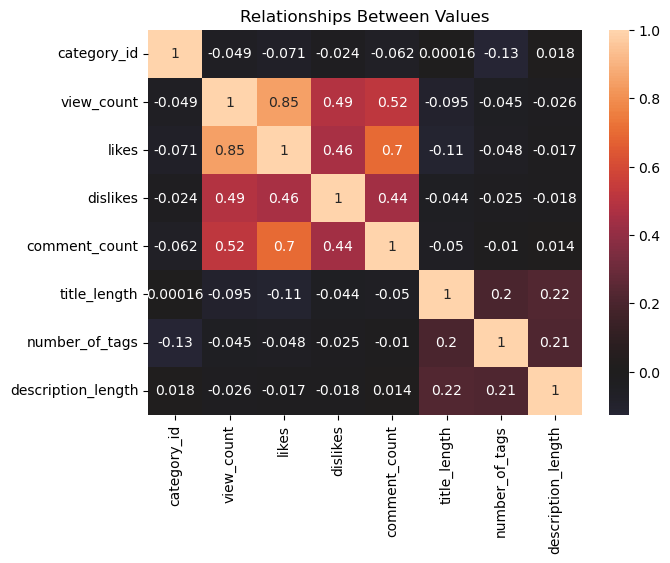

In [23]:
# looking at relationships between some numerical values

numerical_columns = ['category_id', 'view_count', 'likes', 'dislikes', 'comment_count', 'title_length', 'number_of_tags', 'description_length']
numerical_data = data[numerical_columns]

corr_matrix = data[numerical_columns].corr()

# heatmap
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, center=0)
plt.title('Relationships Between Values')
plt.show()

<b> Interpretation: </b>

- <b>view_count vs. likes :</b><br>
    The correlation value is approximately 0.85, indicating a strong positive correlation.
    This means that the number of likes has a strong impact on the view count.
    In other words, videos with more likes tend to have higher view counts.
    <br>
-   <b>view_count vs. dislikes :</b><br>
    The correlation value is around 0.49, indicating a moderate positive correlation.
    This suggests that the number of dislikes influences the view count, but the relationship is weaker compared to likes.
    <br>
- <b>view_count vs. comment_count :</b><br>
    The correlation value is about 0.52, indicating a moderate positive correlation.
    This implies that the number of comments has an impact on the view count, but the relationship is moderate.
    <br>
- <b>likes vs. dislikes :</b><br>
    The correlation value is approximately 0.46, indicating a moderate positive correlation.
    It suggests that the number of likes and dislikes is moderately correlated, but not necessarily strongly.
    <br>
- <b>likes vs. comment_count :</b><br>
    The correlation value is approximately 0.70, indicating a strong positive correlation.
    This means that videos with more likes tend to have a higher number of comments.
- <b>category_id, title_length, number_of_tags and description_length :</b><br> show no correlations

<b>Checking for outliers:</b>

C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\3079107276.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\3079107276.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\3079107276.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\3079107276.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\3079107276.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\3079107276.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\3079107276.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


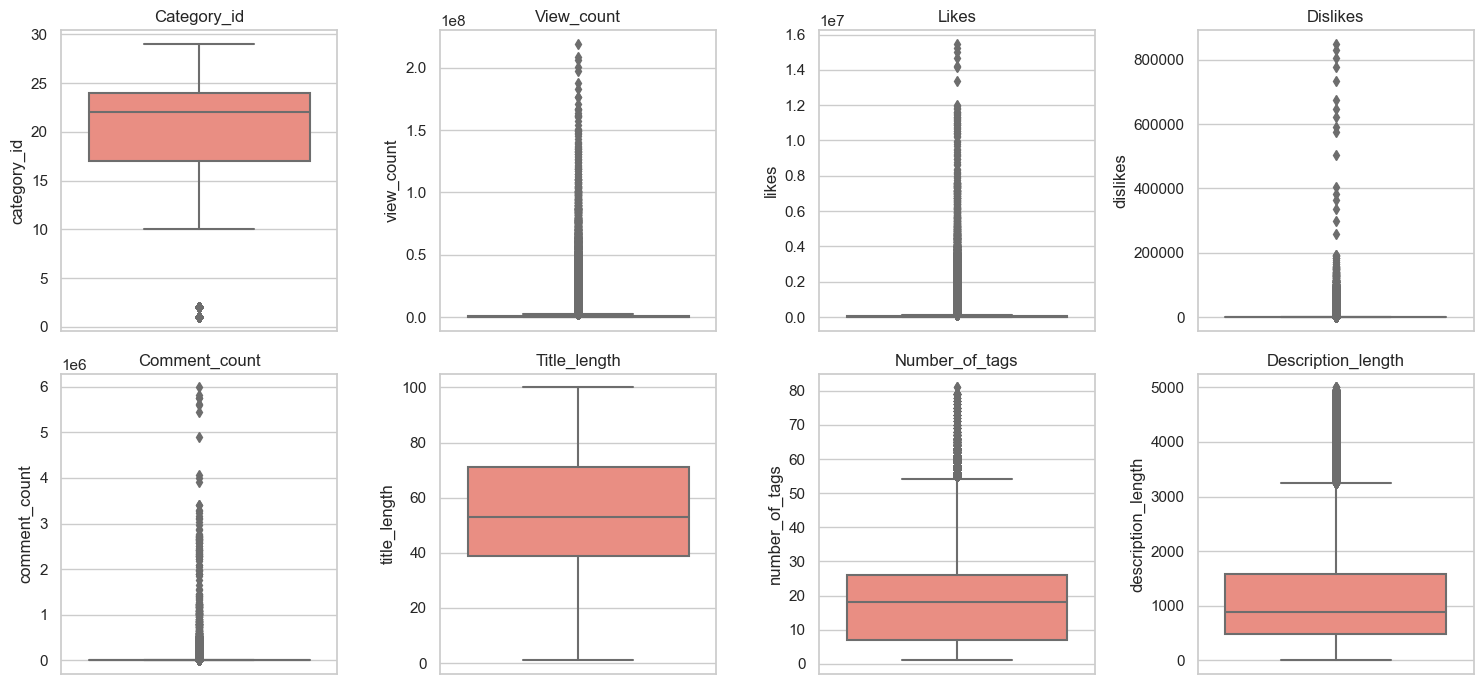

In [24]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 7))
for i in range(len(numerical_columns)):
    plt.subplot(2, 4, i+1)
    sns.boxplot(y=numerical_columns[i], data=data, color='salmon')
    plt.title(numerical_columns[i].capitalize())
    plt.tight_layout()
plt.show()

<b>It can be seen that there are many outliers.</b>

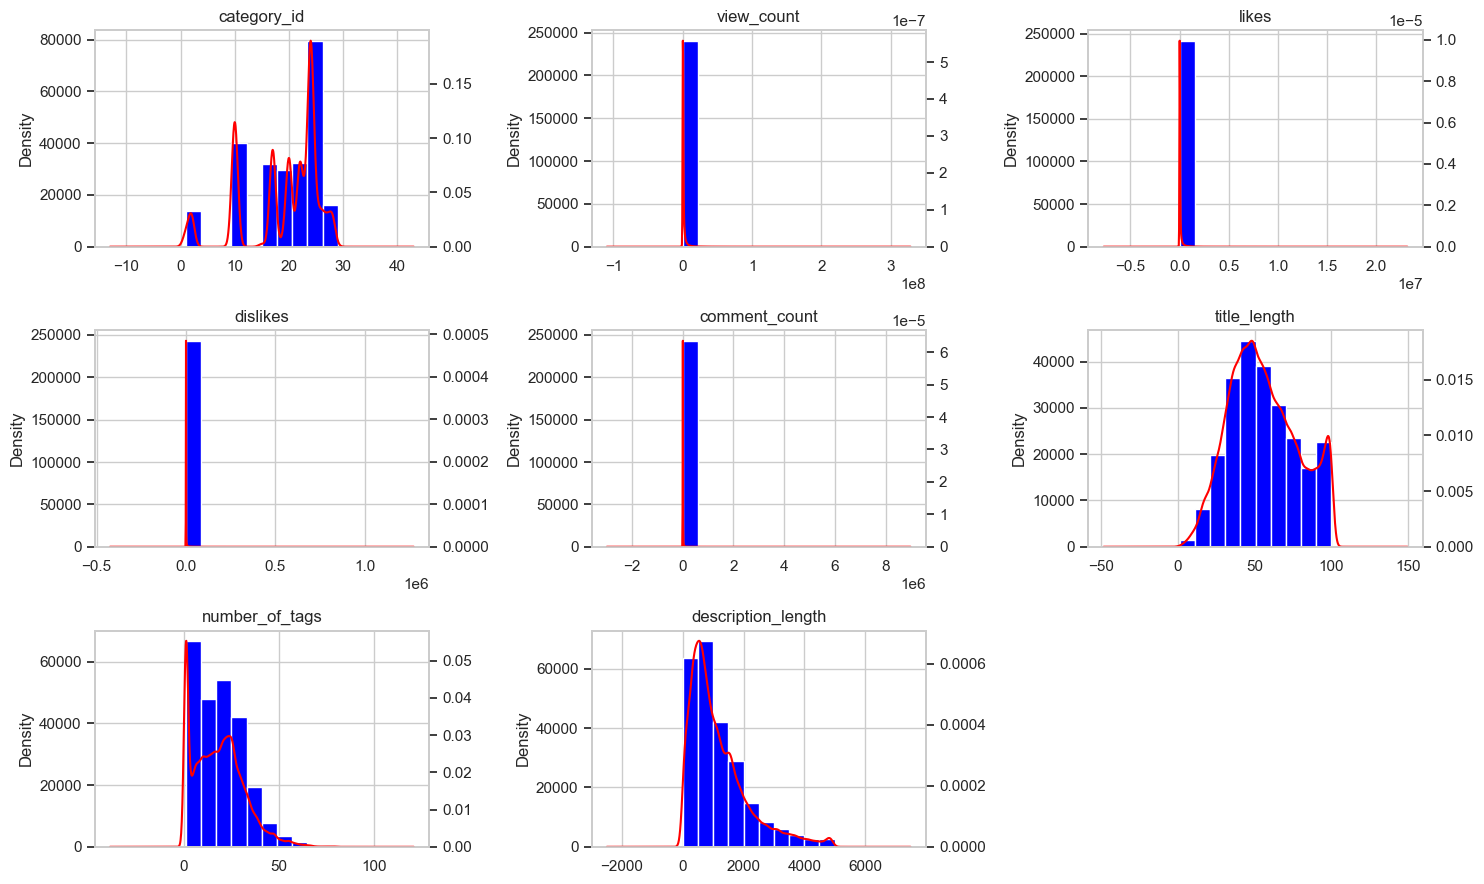

In [25]:
data_num = data[numerical_columns]
k = len(data_num.columns)
n = 3
m = (k - 1) // n + 1
fig, axes = plt.subplots(m, n, figsize=(n * 5, m * 3))

for i, ax in enumerate(axes.flat):
    if i < k:
        col = data_num.iloc[:, i]
        col.hist(ax=ax, color='blue')
        ax2 = col.plot.kde(ax=ax, secondary_y=True, title=col.name, color='red')
        ax2.set_ylim(0)
    else:
        ax.axis('off')
fig.tight_layout()

C:\Users\Acer\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\3692342594.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


<Figure size 1500x1200 with 0 Axes>

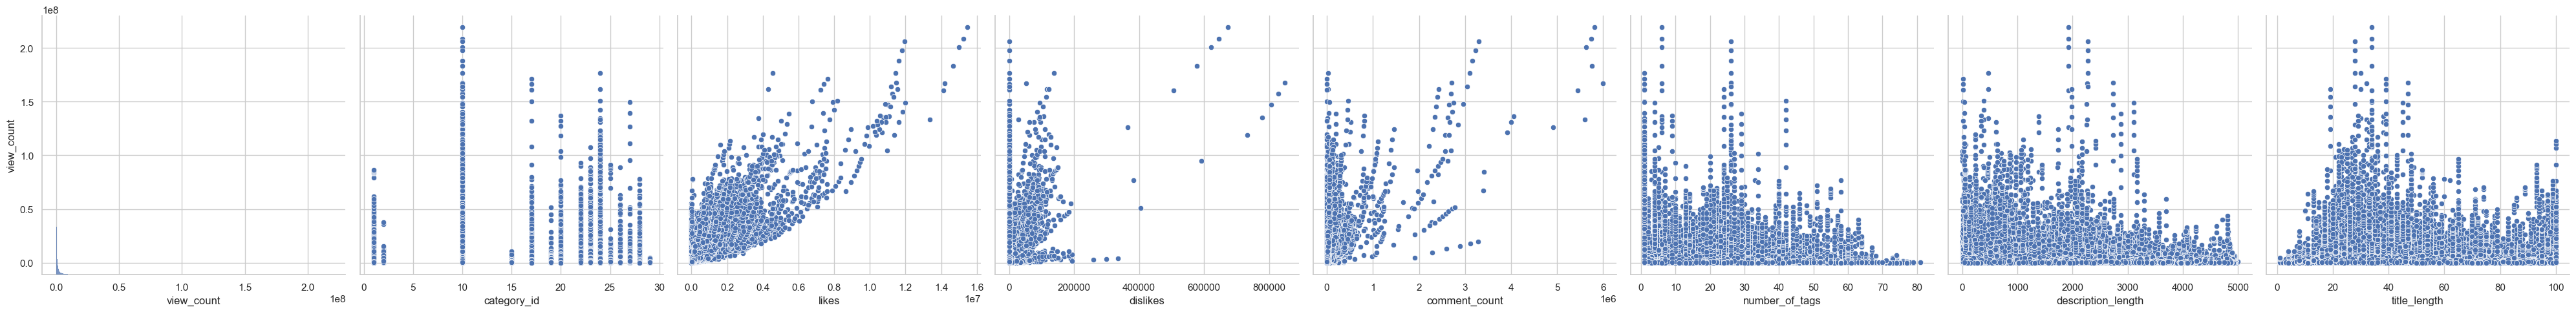

In [26]:
# view_count and other features

plt.figure(figsize=(15, 12))
sns.pairplot(data=data, x_vars=['view_count', 'category_id', 'likes', 'dislikes', 'comment_count', 'number_of_tags', 'description_length', 'title_length'], y_vars=['view_count'], height=5, aspect=1)
plt.tight_layout()
plt.show()

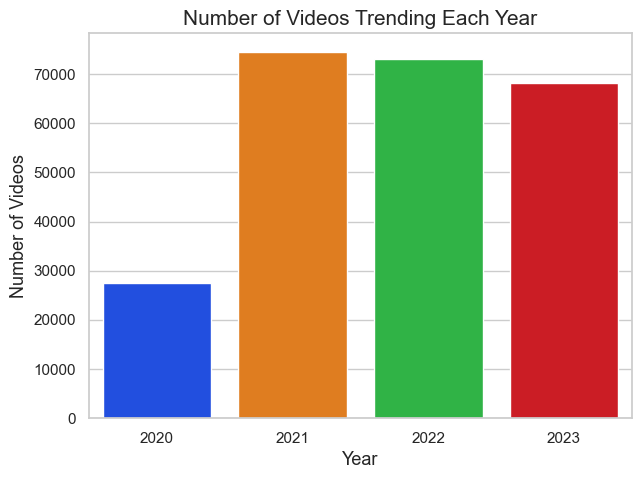

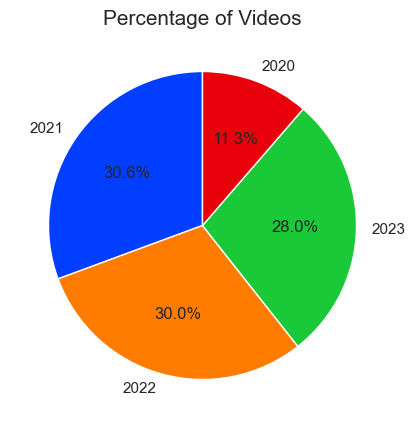

In [90]:
# number of videos trending each year

df_copy = data.copy()
df_copy['year'] = df_copy['trending_date'].dt.year
sns.set(style="whitegrid")
palette = sns.color_palette('bright')

plt.figure(figsize=(7, 5))
sns.countplot(x='year', data=df_copy, palette=palette)
plt.xlabel('Year', fontsize=13)
plt.ylabel('Number of Videos', fontsize=13)
plt.title('Number of Videos Trending Each Year', fontsize=15)
plt.show()

plt.figure(figsize=(5, 5))
df_copy['year'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=palette)
plt.title('Percentage of Videos', fontsize=15)
plt.ylabel('')
plt.show()

In [28]:
print('min date: ', df_copy['trending_date'].min())
print('max date: ', df_copy['trending_date'].max())

min date:  2020-08-12 00:00:00+00:00
max date:  2023-12-10 00:00:00+00:00


<b>The number of videos in years differs because the earliest date in this dataset is 12.08.2020 and the latest date is 10.12.2023, so year 2020 and 2023 are not complete.</b>

In [29]:
# counting the number of titles for each day

video_counts = df_copy.groupby('trending_date')['title'].nunique().reset_index(name='video_count')

average_video_per_day = video_counts['video_count'].mean()
min_video_per_day = video_counts['video_count'].min()
max_video_per_day = video_counts['video_count'].max()

print(f"Average amount of videos per day: {average_video_per_day:.2f}")
print(f"Min amount of videos per day: {min_video_per_day}")
print(f"Max amount of videos per day: {max_video_per_day}")

Average amount of videos per day: 200.41
Min amount of videos per day: 150
Max amount of videos per day: 245


<b>Now we will see which days of the week had the largest numbers of trending videos:</b>

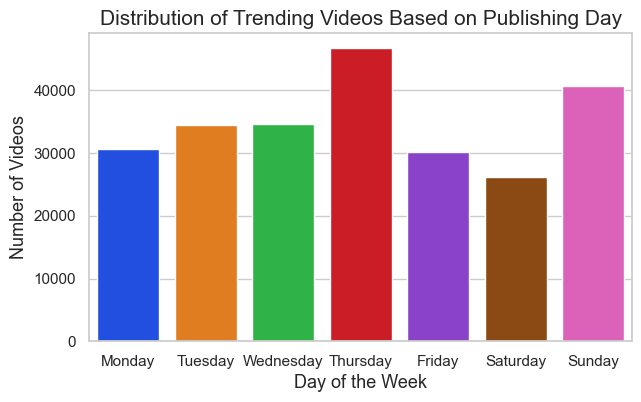

In [30]:
df_copy['published_date'] = pd.to_datetime(df_copy['published_at'])
df_copy['day_of_week'] = df_copy['published_at'].dt.day_name()

plt.figure(figsize=(7, 4))
sns.countplot(x='day_of_week', data=df_copy, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette=palette)
plt.xlabel('Day of the Week', fontsize=13)
plt.ylabel('Number of Videos', fontsize=13)
plt.title('Distribution of Trending Videos Based on Publishing Day', fontsize=15)
plt.show()

<b>We can see that the number of trending videos published on Saturday and Friday are noticeably less than the number of trending videos published on other days of the week, especialy Thursday and Sunday.</b>

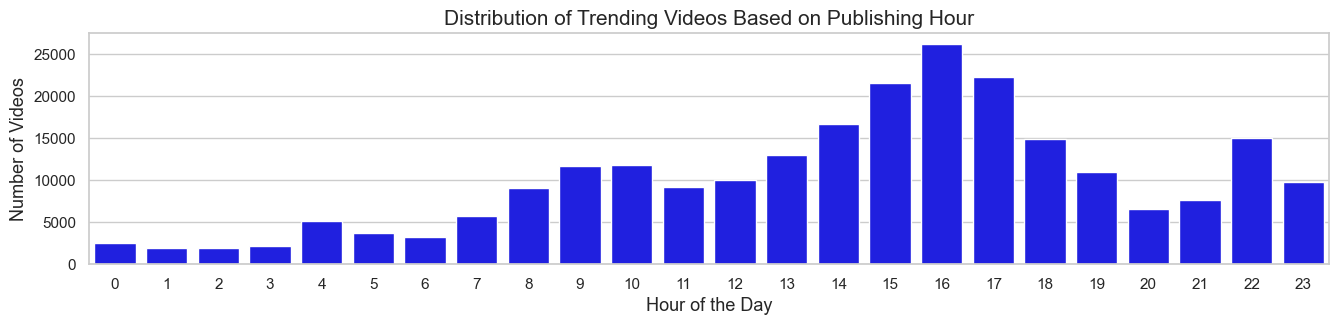

In [31]:
# distribution of trending videos based on the hour of the day

df_copy['hour_of_day'] = df_copy['published_at'].dt.hour

plt.figure(figsize=(16, 3))
sns.countplot(x='hour_of_day', data=df_copy, color='blue')
plt.xlabel('Hour of the Day', fontsize=13)
plt.ylabel('Number of Videos', fontsize=13)
plt.title('Distribution of Trending Videos Based on Publishing Hour', fontsize=15)
plt.show()

<b>We can see that the period between 2 pm and 7 pm, peaking between 3 pm and 5 pm, had the largest number of trending videos. We notice also that the period between 12 am and 6 am has the smallest number of trending videos.</b>

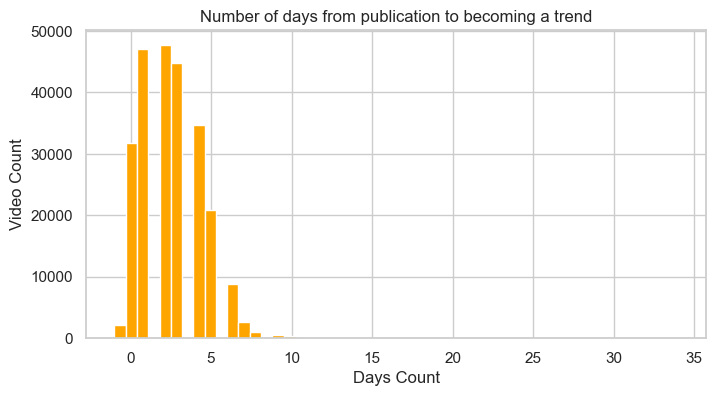

In [32]:
df_copy['trending_date'] = pd.to_datetime(df_copy['trending_date'], format='%Y-%m-%d')
df_copy['published_at'] = pd.to_datetime(df_copy['published_at'], errors='coerce')

df_copy['days_to_trend'] = (df_copy['trending_date'] - df_copy['published_at']).dt.days

df_copy = df_copy.dropna(subset=['days_to_trend'])

plt.figure(figsize=(8, 4))
plt.hist(df_copy['days_to_trend'], bins=50, color='orange')
plt.xlabel('Days Count')
plt.ylabel('Video Count')
plt.title('Number of days from publication to becoming a trend')
plt.show()


<b>In this chart illustrating the duration from video publication to trending status, a noticeable trend emerges. The majority of videos attain trending status on the very day of their release, indicating an immediate surge in popularity. Following this, the distribution of videos trending for 1 - 3 days appears quite similar, suggesting a relatively brief period of sustained popularity.</b>

In [33]:
df_copy['days_to_trend'].replace({-1:0},inplace=True)

In [34]:
df_copy['days_to_trend'].max()

34

In [35]:
df_copy['days_to_trend'].min()

0

<b>We can see that some videos trended on the same day they were published and for some videos it took 34 days to trend after being published.</b>

In [36]:
df_copy[['view_count', 'likes', 'dislikes', 'comment_count']].describe().T

count          mean           std  min       25%       50%  \
view_count     243336.0  1.582314e+06  5.554451e+06  0.0  129902.0  318233.5   
likes          243336.0  8.451097e+04  3.371838e+05  0.0    5311.0   14292.5   
dislikes       243336.0  9.672774e+02  7.359679e+03  0.0       0.0       0.0   
comment_count  243336.0  6.413232e+03  6.158776e+04  0.0     304.0     822.0   

                      75%          max  
view_count     1005942.25  219110491.0  
likes            47424.25   15460845.0  
dislikes           196.00     848975.0  
comment_count     2726.00    5987755.0

<b>Some insights from the data from the table above:</b>
- The majority of videos have a moderate number of views, with the average being around 1.58 million.
    Variation in viewership indicates diverse popularity among trending videos.
- The average number of likes per video is relatively high at around 84,511. Viewers tend to show positive reactions through likes, contributing to the overall high engagement.
- Dislikes are generally low, with an average of 967 per video. Most videos receive minimal negative feedback, suggesting a favorable reception from the audience.
- Videos, on average, attract around 6,413 comments.
    There is a wide range of audience interactions, from a few hundred to several million comments.

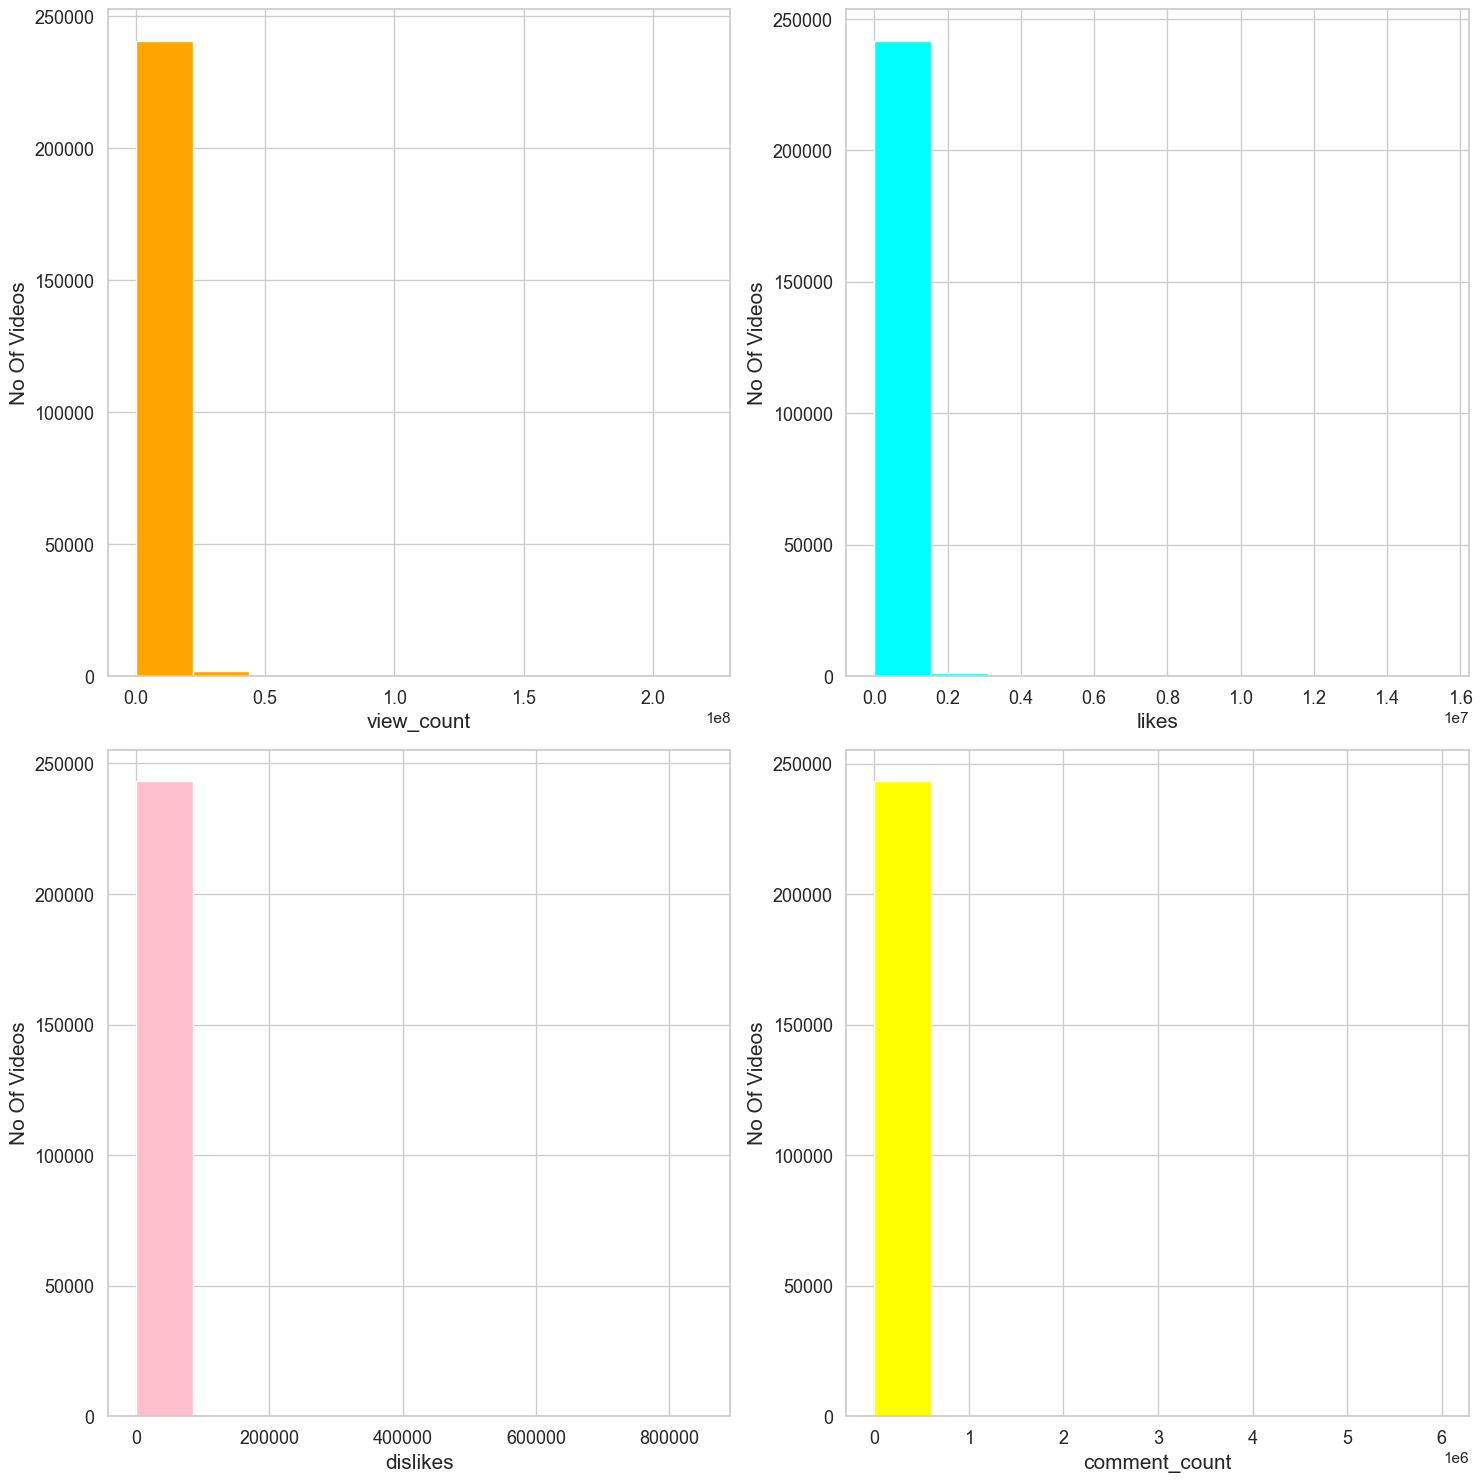

In [37]:
cols = ['view_count', 'likes', 'dislikes', 'comment_count']
color = ['orange', 'cyan', 'pink', 'yellow']
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for var,i,subplot in zip(cols,color, ax.flatten()):
    ax=df_copy[var].hist(ax=subplot,ylabelsize=13,xlabelsize=13,color=i)
    ax.set_xlabel(var,fontsize=15)
    ax.set_ylabel("No Of Videos",fontsize=15)
fig.tight_layout()

<b>And limited range for a closer look:</b>

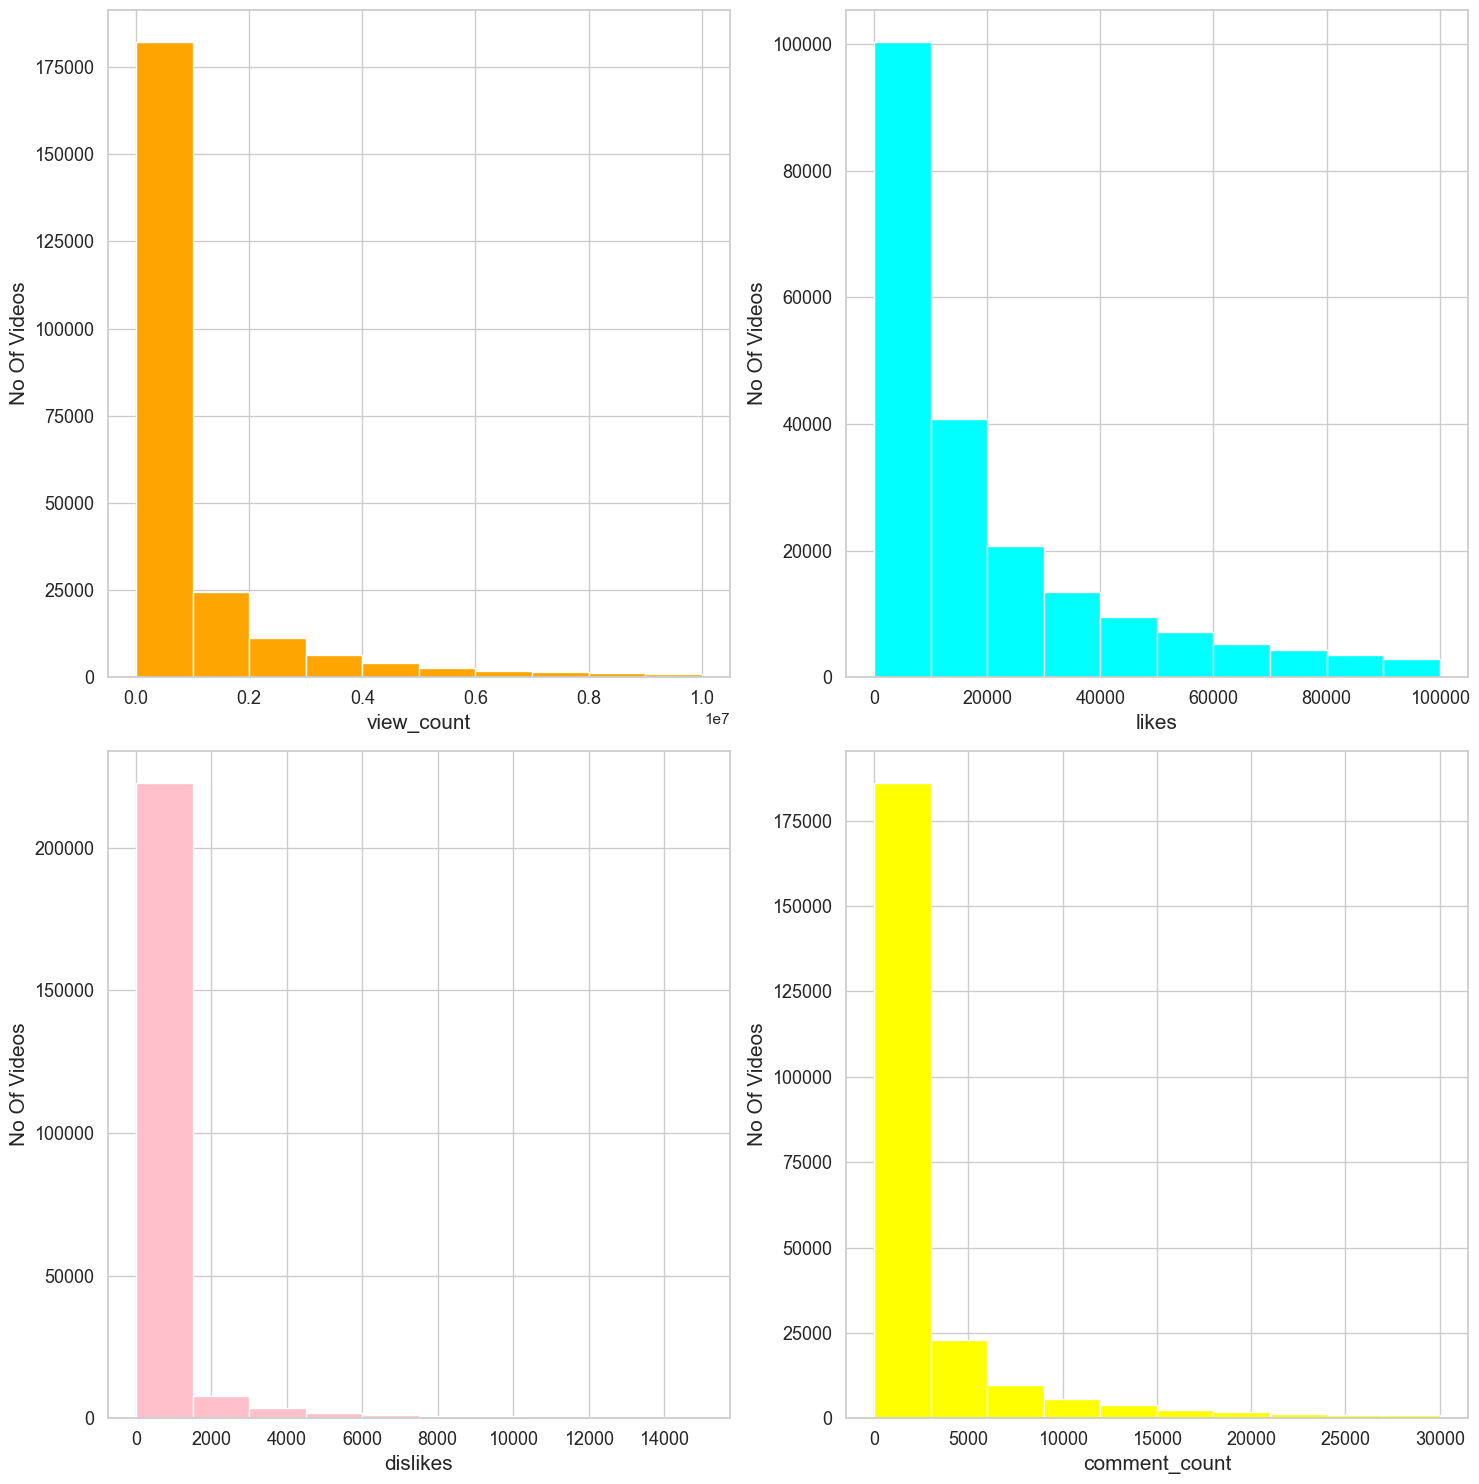

In [38]:
r=[10000000,100000,15000,30000,40]
fig, ax = plt.subplots(2, 2, figsize=(15, 15))
for var,i,j,subplot in zip(cols,r,color, ax.flatten()):
    ax=df_copy[df_copy[var]<=i][var].hist(ax=subplot,ylabelsize=13,xlabelsize=13,color=j)
    ax.set_xlabel(var,fontsize=15)
    ax.set_ylabel("No Of Videos",fontsize=15)
fig.tight_layout()

<b>We can see that majority of the videos trend have 1 million views or less, 20 milions  or less likes, 1500 or less dislikes, 3000 comments or less.</b>

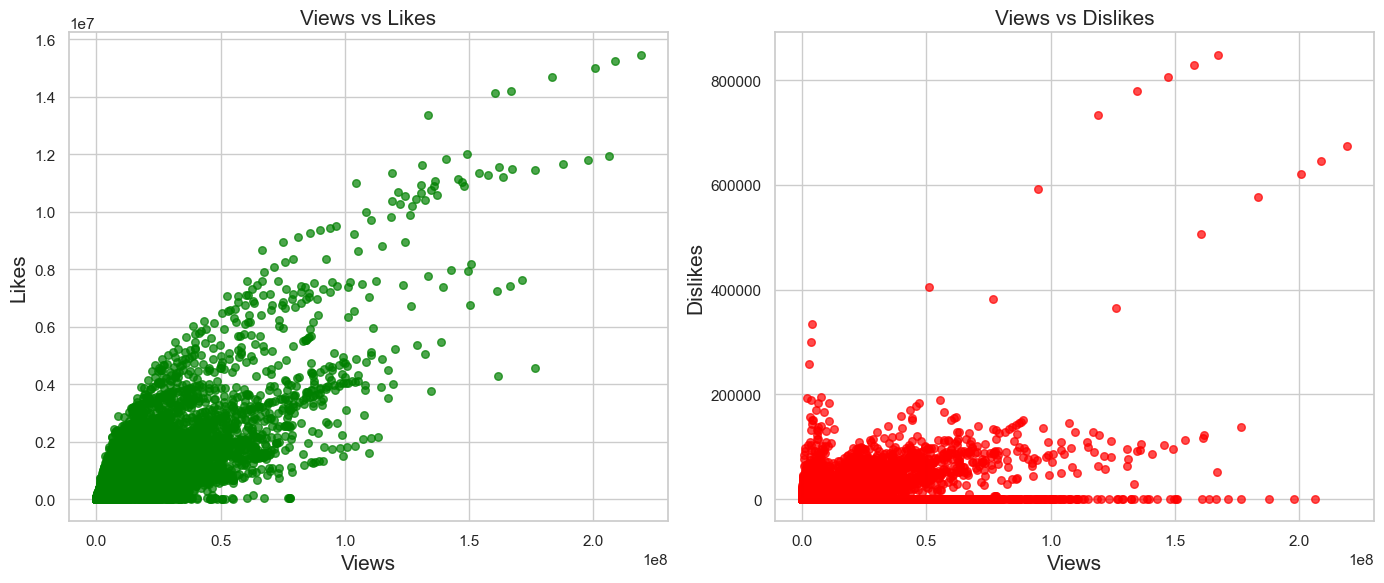

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Likes
ax1.scatter(df_copy['view_count'], df_copy['likes'], c='green', alpha=0.7, s=30)
ax1.set_xlabel("Views", size=15)
ax1.set_ylabel("Likes", size=15)
ax1.set_title('Views vs Likes', size=15)

# Dislikes
ax2.scatter(df_copy['view_count'], df_copy['dislikes'], c='red', alpha=0.7, s=30)
ax2.set_xlabel("Views", size=15)
ax2.set_ylabel("Dislikes", size=15)
ax2.set_title('Views vs Dislikes', size=15)

plt.tight_layout()
plt.show()

<b>There is a strong linear relation between the number of views and the number of likes on a video. We see that views and likes are truly positively correlated: as one increases, the other increases too (mostly).</b>

<b>Languages in titles:</b>

In [40]:
def classify_language(text):
    lang, _ = langid.classify(text)
    return lang

# creating a new language classification column for title_cleaned
df_copy['language'] = df_copy['title_cleaned'].apply(classify_language)

# counting the number of titles in German and other languages
german_count = df_copy[df_copy['language'] == 'de'].shape[0]
other_count = df_copy[df_copy['language'] != 'de'].shape[0]

total_count = len(df_copy)

# counting percent
german_percentage = (german_count / total_count) * 100
other_percentage = (other_count / total_count) * 100

print(f"Number of titles in German: {german_count} ({german_percentage:.2f}%)")
print(f"Number of titles in other languages: {other_count} ({other_percentage:.2f}%)")

Number of titles in German: 97889 (40.23%)
Number of titles in other languages: 145447 (59.77%)


In [41]:
# using langid to classify the language

def classify_language(text):
    lang, _ = langid.classify(text)
    return lang

language_counts = df_copy.groupby('language').size().reset_index(name='counts')

total_count = len(df_copy)

language_counts['percentage'] = (language_counts['counts'] / total_count) * 100

print(f"Number of titles in each language:")
for index, row in language_counts.iterrows():
    language = row['language']
    count = row['counts']
    percentage = row['percentage']
    print(f"{language}: {count} titles ({percentage:.2f}%)")

Number of titles in each language:
af: 1205 titles (0.50%)
am: 45 titles (0.02%)
an: 468 titles (0.19%)
ar: 623 titles (0.26%)
az: 174 titles (0.07%)
bg: 14 titles (0.01%)
br: 1020 titles (0.42%)
bs: 164 titles (0.07%)
ca: 669 titles (0.27%)
cs: 324 titles (0.13%)
cy: 767 titles (0.32%)
da: 3518 titles (1.45%)
de: 97889 titles (40.23%)
el: 21 titles (0.01%)
en: 71115 titles (29.23%)
eo: 840 titles (0.35%)
es: 6509 titles (2.67%)
et: 1967 titles (0.81%)
eu: 2316 titles (0.95%)
fa: 48 titles (0.02%)
fi: 1712 titles (0.70%)
fo: 112 titles (0.05%)
fr: 6926 titles (2.85%)
ga: 386 titles (0.16%)
gl: 144 titles (0.06%)
he: 4 titles (0.00%)
hr: 527 titles (0.22%)
ht: 127 titles (0.05%)
hu: 1001 titles (0.41%)
hy: 5 titles (0.00%)
id: 2418 titles (0.99%)
is: 133 titles (0.05%)
it: 5774 titles (2.37%)
ja: 39 titles (0.02%)
jv: 395 titles (0.16%)
ka: 11 titles (0.00%)
kk: 2 titles (0.00%)
ko: 1585 titles (0.65%)
ku: 31 titles (0.01%)
ky: 16 titles (0.01%)
la: 230 titles (0.09%)
lb: 1082 titles (0

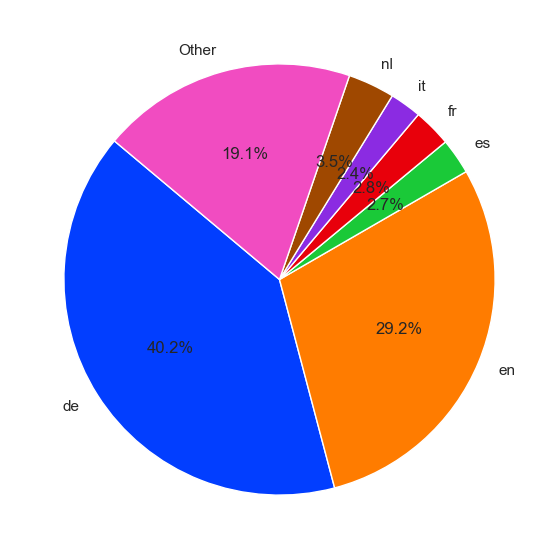

In [42]:
sns.set_palette('bright')

# filtering for languages of 2% or more
major_languages = language_counts[language_counts['percentage'] >= 2]

# 'other' for languages under 2%
other_languages = language_counts[language_counts['percentage'] < 2]
other_language_count = other_languages['counts'].sum()
other_language_percentage = other_languages['percentage'].sum()
other_languages = pd.DataFrame({'language': ['Other'], 'counts': [other_language_count], 'percentage': [other_language_percentage]})

# combining all
combined_data = pd.concat([major_languages, other_languages])

plt.figure(figsize=(7, 7))
plt.pie(combined_data['counts'], labels=combined_data['language'], autopct='%1.1f%%', startangle=140)
plt.show()

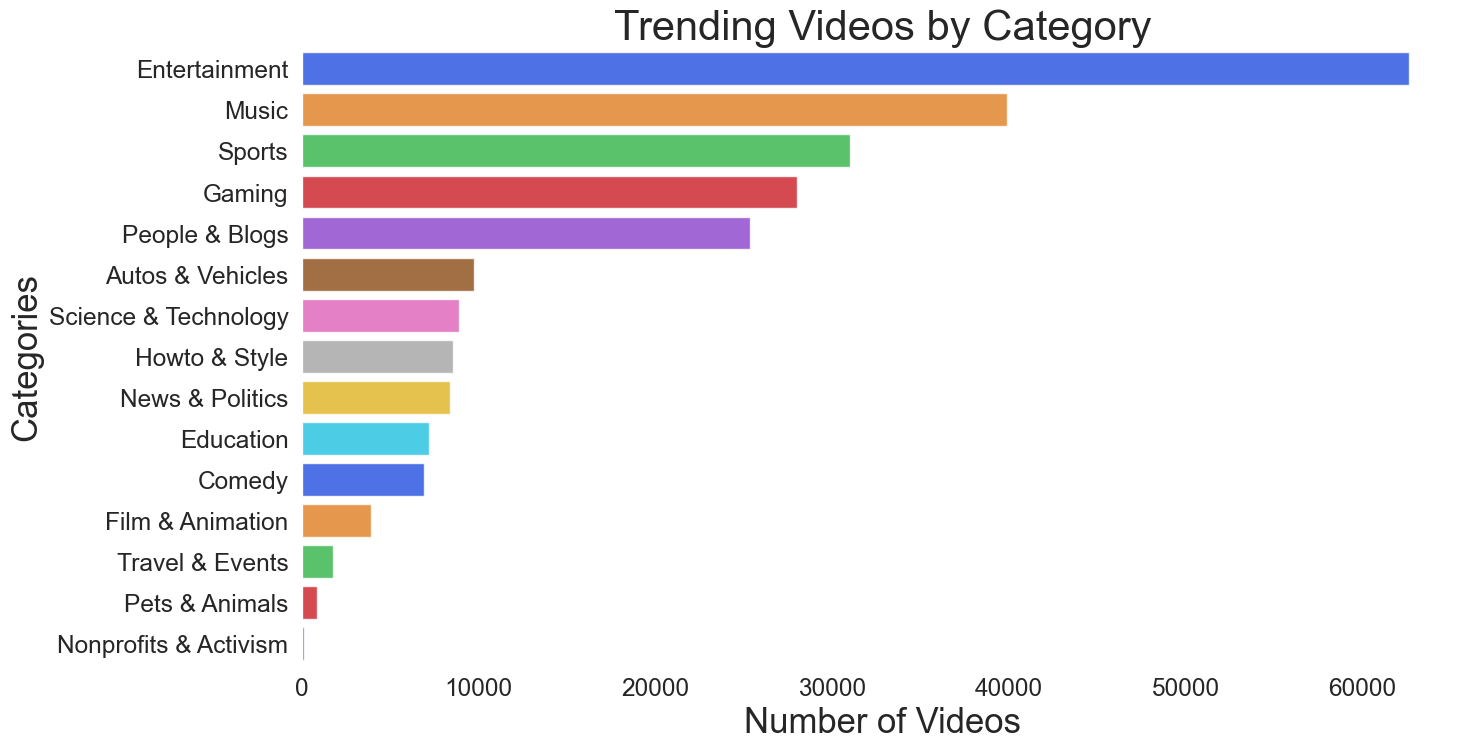

In [43]:
# number of trending videos per category 

sns.set_theme(style="whitegrid")
sns.set(font_scale=1.6)
categories = df_copy['category_name'].value_counts()
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_facecolor('None')
sns.barplot(x=categories.values, y=categories.index, alpha=0.8, palette="bright", ax=ax)  
plt.xlabel('Number of Videos', fontsize=25) 
plt.ylabel('Categories', fontsize=25)
plt.title('Trending Videos by Category', fontsize=30)
sns.despine()
plt.show()

<b>We see that the Entertainment category contains the largest number of trending videos with around 60,000 videos, followed by Music category with around 40,000 videos, followed by Sports category with around 35,000 videos, and so on.</b>

<b>Now we will see which category has the maximum likes:</b>

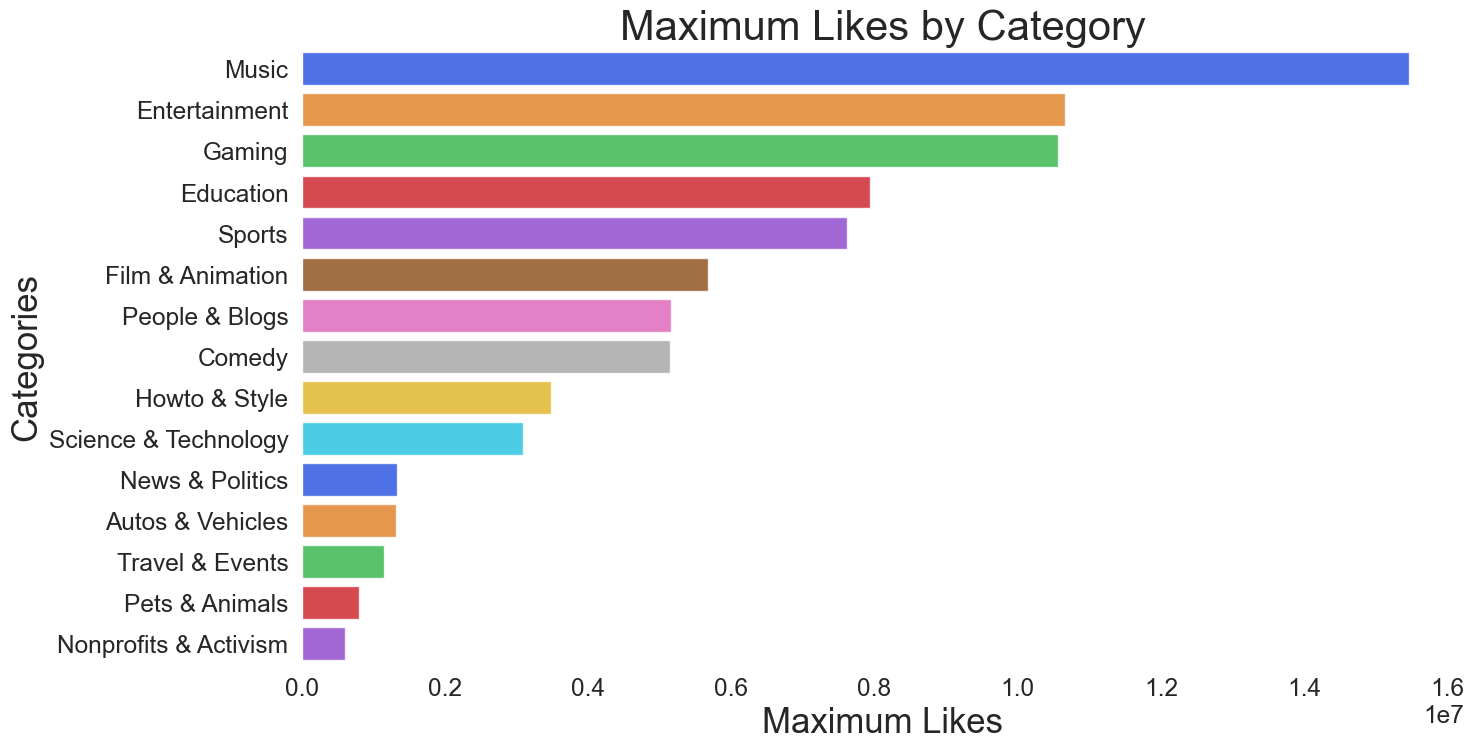

In [44]:
sns.set_theme(style="whitegrid")
sns.set(font_scale=1.6)
likes_max_per_category = df_copy.groupby('category_name')['likes'].max().sort_values(ascending=False)
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_facecolor('None')  
sns.barplot(x=likes_max_per_category.values, y=likes_max_per_category.index, alpha=0.8, palette="bright", ax=ax)  
plt.xlabel('Maximum Likes', fontsize=25) 
plt.ylabel('Categories', fontsize=25)
plt.title('Maximum Likes by Category', fontsize=30)
sns.despine()
plt.show()

<b>Music, Entertainment and Gaming have the most likes - in all these three categories, there are often strong fan communities ready to support their favorite artists and content creators and this community engagement can translate into a high number of likes. In the case of the Music category, also high music quality, attractive music videos and popular artists can attract many likes.</b>

<b>Now that we know what category of videos are popular on Youtube Germany, let’s try to understand the kind of tags that are used by the most popular videos. This will help us understand more about the kind of tags that are likely to make a video trend (or go viral) in Germany.</b>

In [45]:
# counter directly on the flattened list of tokens
word_counter = Counter(token for title in df_copy['title_cleaned'] for token in title.split())

# 50 most common words and their frequencies
top_words_and_freqs = word_counter.most_common(50)
top_words, freqs = zip(*top_words_and_freqs)

# converting to lists
top_words = list(top_words)
freqs = list(freqs)

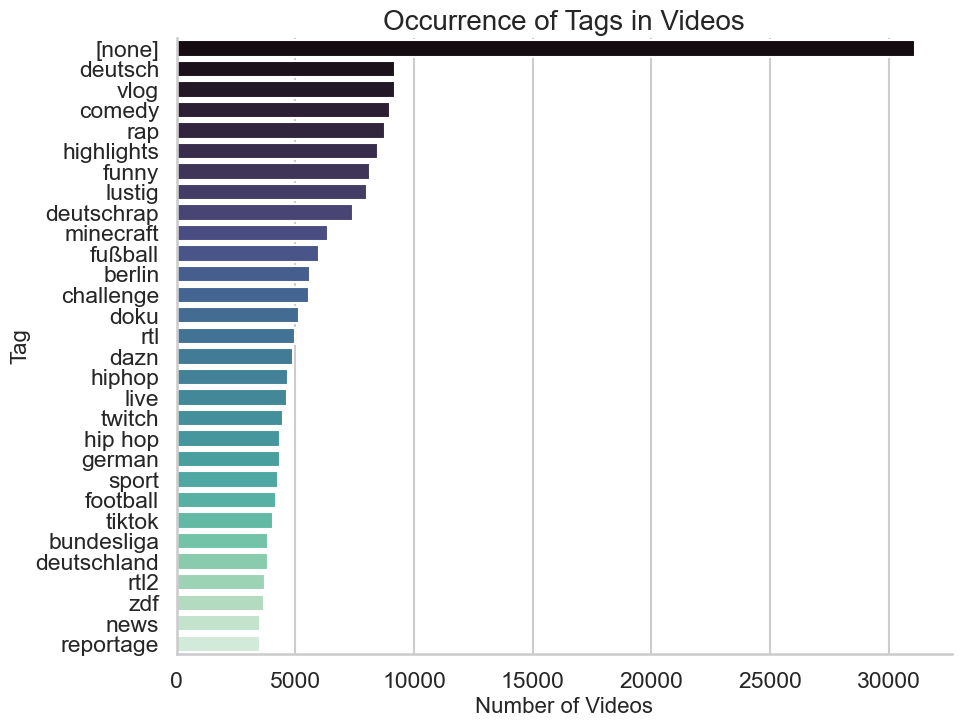

In [46]:
tag_list = [tag for tags in df_copy['tags'] for tag in tags]

# counter directly on the flattened list of tags
tag_counter = Counter(tag_list)

# 20 most common tags and their frequencies
top_tags_and_freqs = tag_counter.most_common(30)
top_tags, tag_freqs = zip(*top_tags_and_freqs)

# converting to lists
top_tags = list(top_tags)
tag_freqs = list(tag_freqs)

# DataFrame with the results
tags_df = pd.DataFrame({'Tag': top_tags, 'Number of Videos': tag_freqs})

sns.set_theme(context="talk", style="whitegrid")
plt.figure(figsize=(10, 8), facecolor='None') 
sns.barplot(x=tag_freqs, y=top_tags, palette="mako")  
plt.xlabel('Number of Videos', fontsize=16) 
plt.ylabel('Tag', fontsize=16)
plt.title('Occurrence of Tags in Videos', fontsize=20)
sns.despine()
plt.show()

<b>Most of videos didn't have any tags, but for those which had, as it can be seen, there are lots of references to world like "deutsch", "vlog" and "comedy". </b>

In [47]:
display(tags_df)

Tag  Number of Videos
0        [none]             31090
1       deutsch              9202
2          vlog              9188
3        comedy              8988
4           rap              8771
5    highlights              8470
6         funny              8138
7        lustig              8010
8    deutschrap              7429
9     minecraft              6375
10      fußball              5979
11       berlin              5627
12    challenge              5556
13         doku              5171
14          rtl              4996
15         dazn              4882
16       hiphop              4706
17         live              4657
18       twitch              4468
19      hip hop              4339
20       german              4338
21        sport              4285
22     football              4200
23       tiktok              4043
24   bundesliga              3862
25  deutschland              3846
26         rtl2              3738
27          zdf              3673
28         news              3527
29    reportage              3513

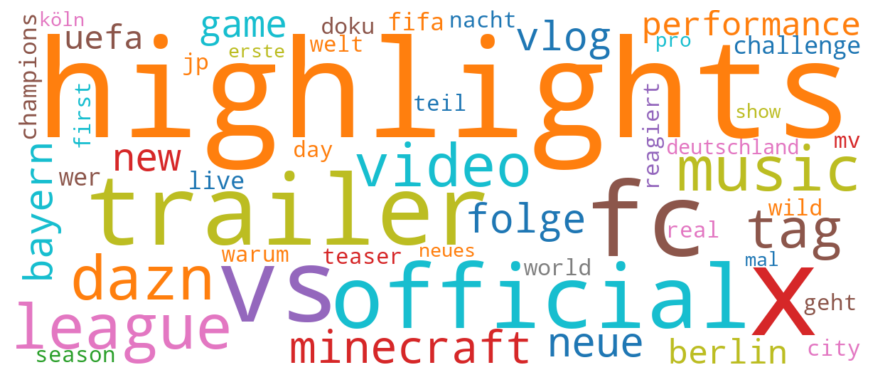

In [48]:
# create a dictionary of word frequencies
word_freq_dict = dict(zip(top_words, freqs))

wc = WordCloud(width=1200, height=500, collocations=False, background_color="white", colormap="tab10")

# generating the WordCloud
wordcloud = wc.generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(11, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

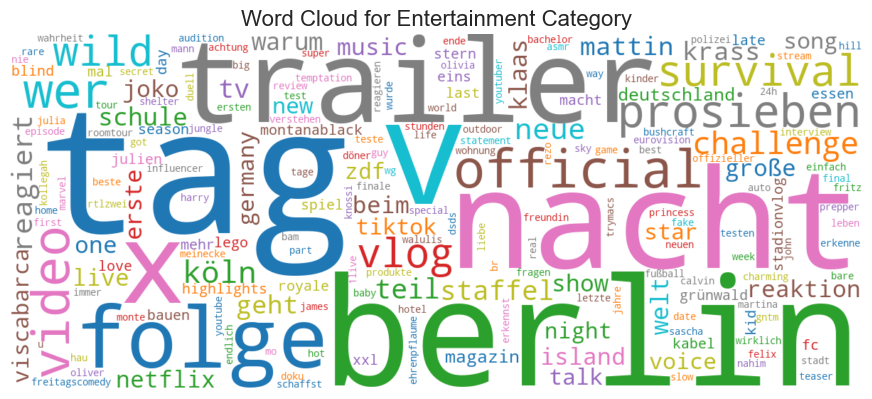

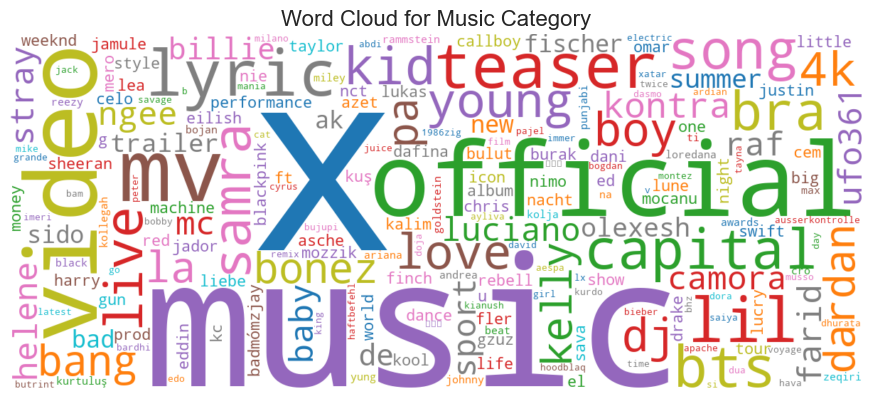

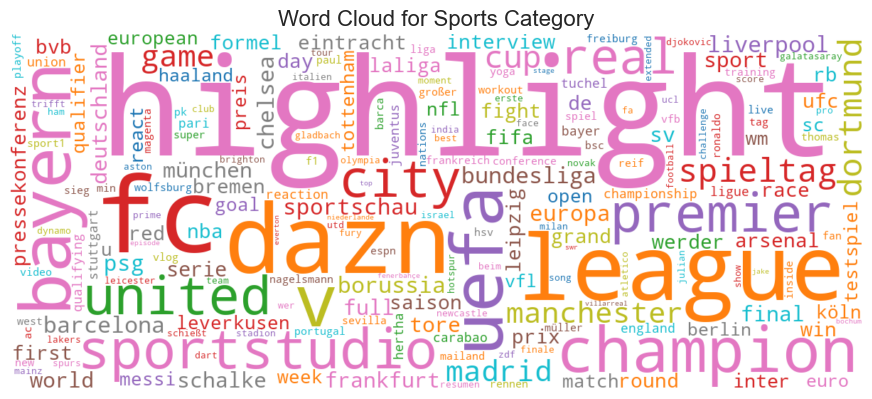

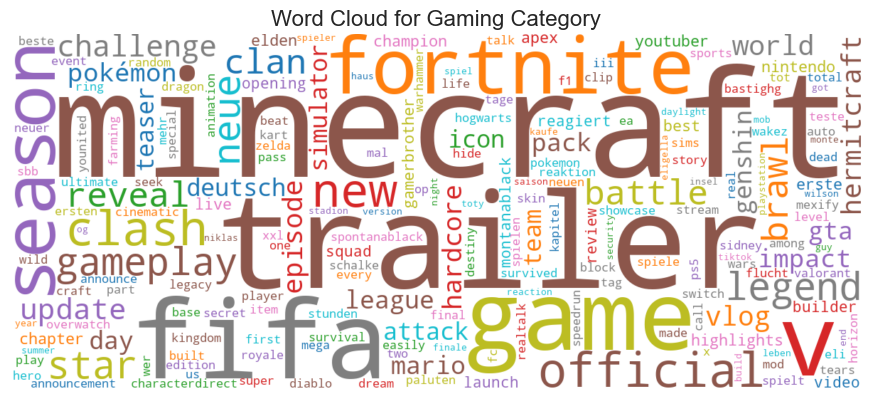

In [49]:
# function to generate Word Cloud for a specific category

def generate_wordcloud(category_name, title_cleaned):
    category_words = title_cleaned[df_copy['category_name'] == category_name]
    title_words = [token for title in category_words for token in title.split()]

    wc_category = WordCloud(width=1200, height=500, collocations=False, background_color="white", colormap="tab10")
    wordcloud_category = wc_category.generate(" ".join(title_words))

    plt.figure(figsize=(11, 8))
    plt.imshow(wordcloud_category, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Word Cloud for {category_name} Category', fontsize=16)
    plt.show()

generate_wordcloud("Entertainment", df_copy['title_cleaned'])
generate_wordcloud("Music", df_copy['title_cleaned'])
generate_wordcloud("Sports", df_copy['title_cleaned'])
generate_wordcloud("Gaming", df_copy['title_cleaned'])

In [50]:
channels = df_copy.channel_title.value_counts()
channels.head(10)

channel_title
JP Performance                1299
Sky Sport HD                  1136
Berlin - Tag & Nacht          1092
sportstudio fußball            909
DAZN UEFA Champions League     848
Köln 50667                     735
Sportschau                     709
tagesschau                     700
Varion                         692
DAZN Fußball International     685
Name: count, dtype: int64

<b>Videos from 3 channels were trending for most period that the data was collected. Now I'll visualize the distribution of trending channels trending over the period of collected data.</b>


<b>Lets see which chanels have a large number of trending videos.</b>

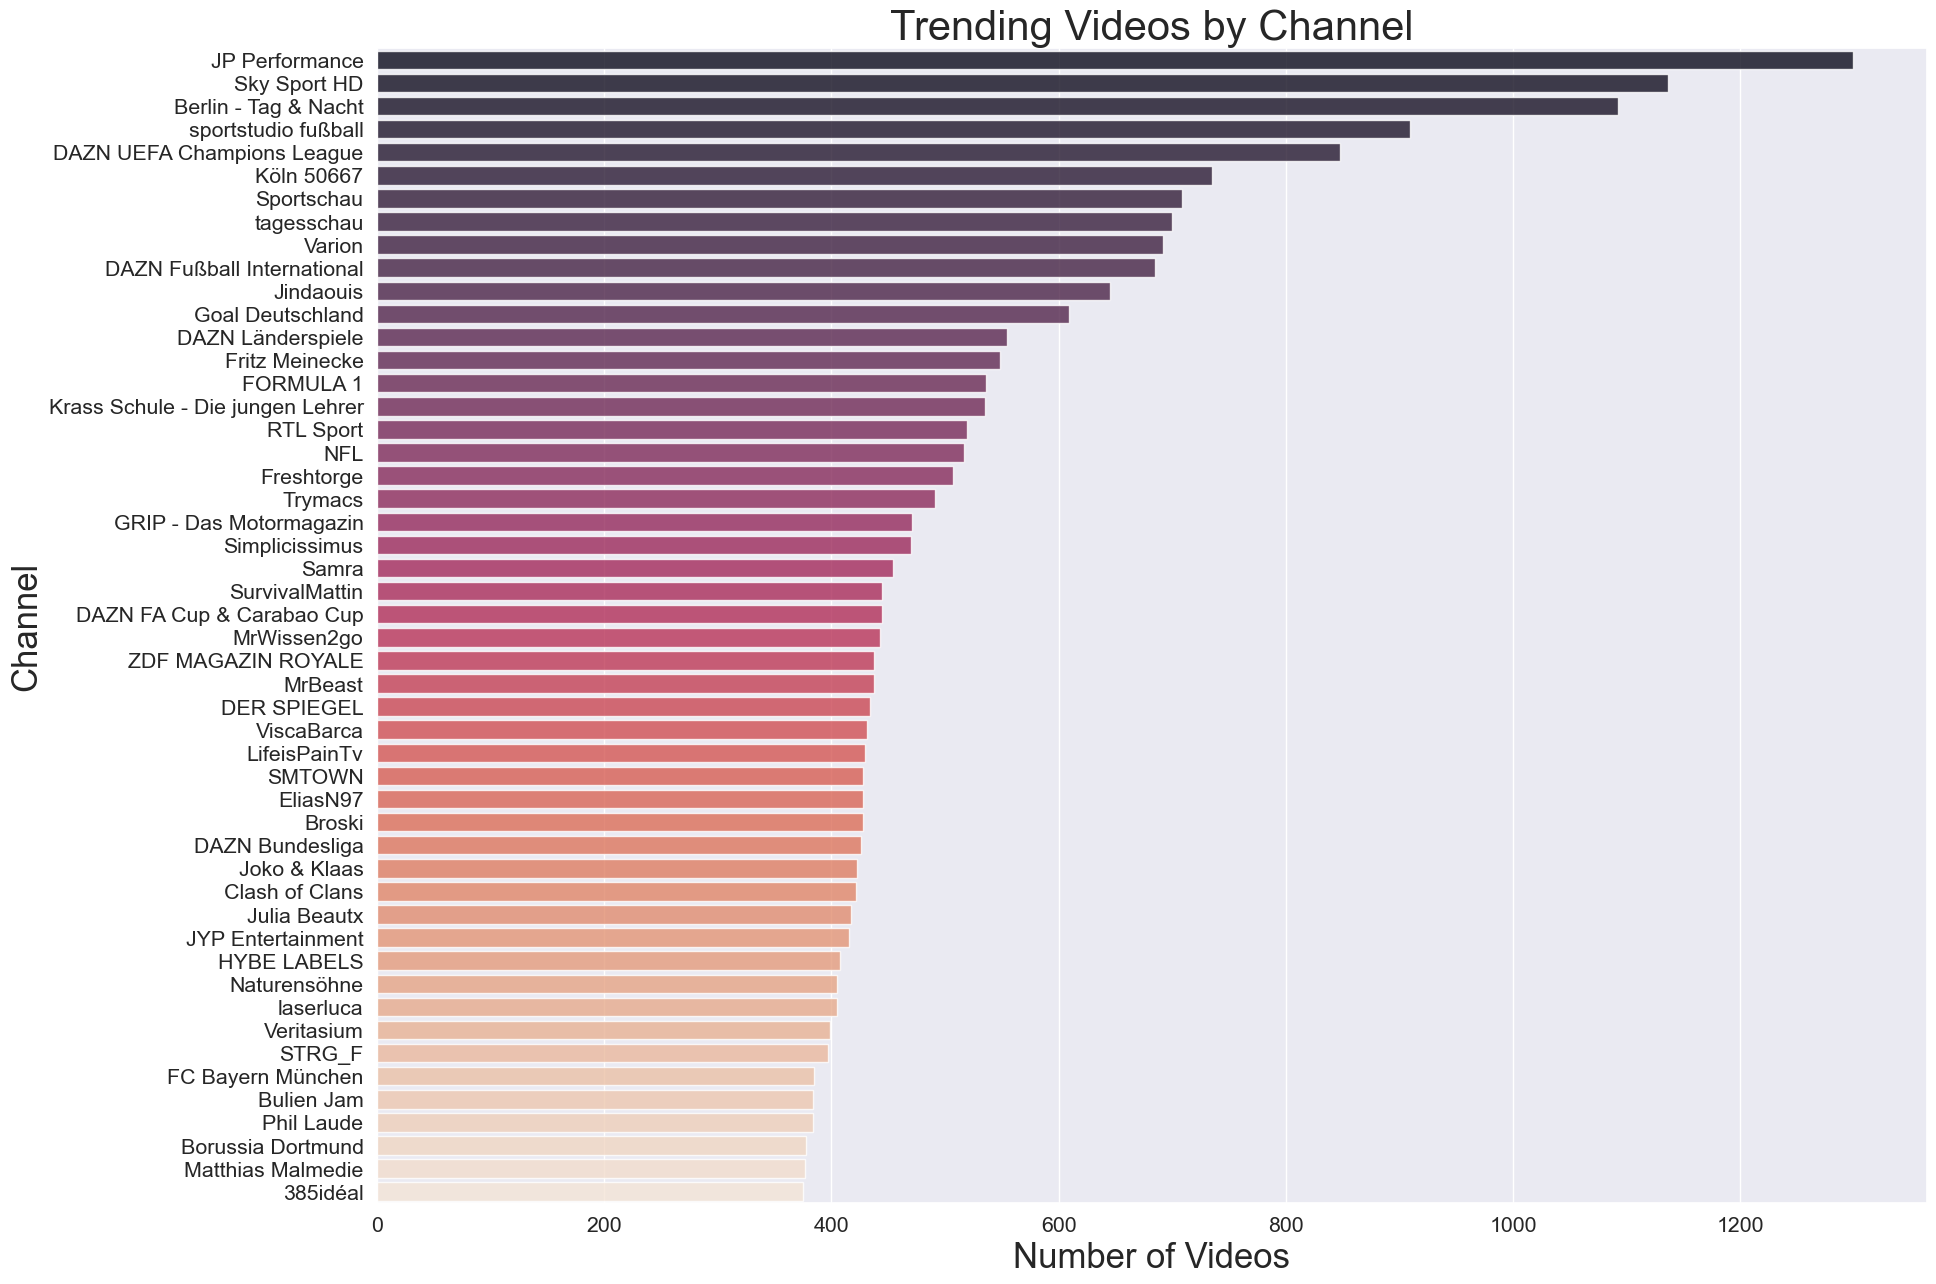

In [51]:
sns.set_style("darkgrid")
sns.set(font_scale=1.4)

channel_freq = df_copy['channel_title'].value_counts()
channel_freq = channel_freq[0:50]
plt.figure(figsize=(20, 15))
sns.barplot(x=channel_freq.values, y=channel_freq.index, alpha=0.8, palette="rocket")
plt.ylabel('Channel', fontsize=25)
plt.xlabel('Number of Videos', fontsize=25)
plt.title('Trending Videos by Channel', fontsize=30)
plt.show()

In [52]:
top_channel = df_copy['channel_title'].value_counts().idxmax()
top_channel_videos = df_copy[df_copy['channel_title'] == top_channel].head(10)
unique_titles = top_channel_videos['title'].unique()

print("Top video titles of top channel:")
for title in unique_titles:
    print(title)

Top video titles of top channel:
JP Performance - Machen wir ihn schneller? | Opel Speedster + Tuning auf der LaSiSe
JP Performance - Zu Besuch bei NOVITEC! | Mclaren 720s | Carbon-Parts + Felgen
JP Performance - Rouvens Audi Coupé Projekt
JP Performance - Ihr fragt/Ich antworte! #79


In [53]:
# video with most likes
most_likes_video = df_copy[df_copy['likes'] == df_copy['likes'].max()]
print("Video with the most likes::")
print(most_likes_video[['title', 'likes', 'dislikes', 'view_count']])

# video with most dislikes
most_dislikes_video = df_copy[df_copy['dislikes'] == df_copy['dislikes'].max()]
print("\nVideo with the most dislikes:")
print(most_dislikes_video[['title', 'likes', 'dislikes', 'view_count']])

# video with most views
most_views_video = df_copy[df_copy['view_count'] == df_copy['view_count'].max()]
print("\nVideo with the most views:")
print(most_views_video[['title', 'likes', 'dislikes', 'view_count']])

Video with the most likes::
                                   title     likes  dislikes  view_count
3152  BTS (방탄소년단) 'Dynamite' Official MV  15460845    674292   219110491

Video with the most dislikes:
                                                title     likes  dislikes  \
4582  BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V  11474616    848975   

      view_count  
4582   167334429  

Video with the most views:
                                   title     likes  dislikes  view_count
3152  BTS (방탄소년단) 'Dynamite' Official MV  15460845    674292   219110491


C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\3707525126.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='trending_date', y='view_count', data=df_copy, estimator='mean', ci=None, label='Views', color='blue')
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\3707525126.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='trending_date', y='likes', data=df_copy, estimator='mean', ci=None, label='Likes', color='green')
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\3707525126.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='trending_date', y='dislikes', data=df_copy, estimator='mean', ci=None, label='Dislikes', color='red', linewidth=2)
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\3707525126.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

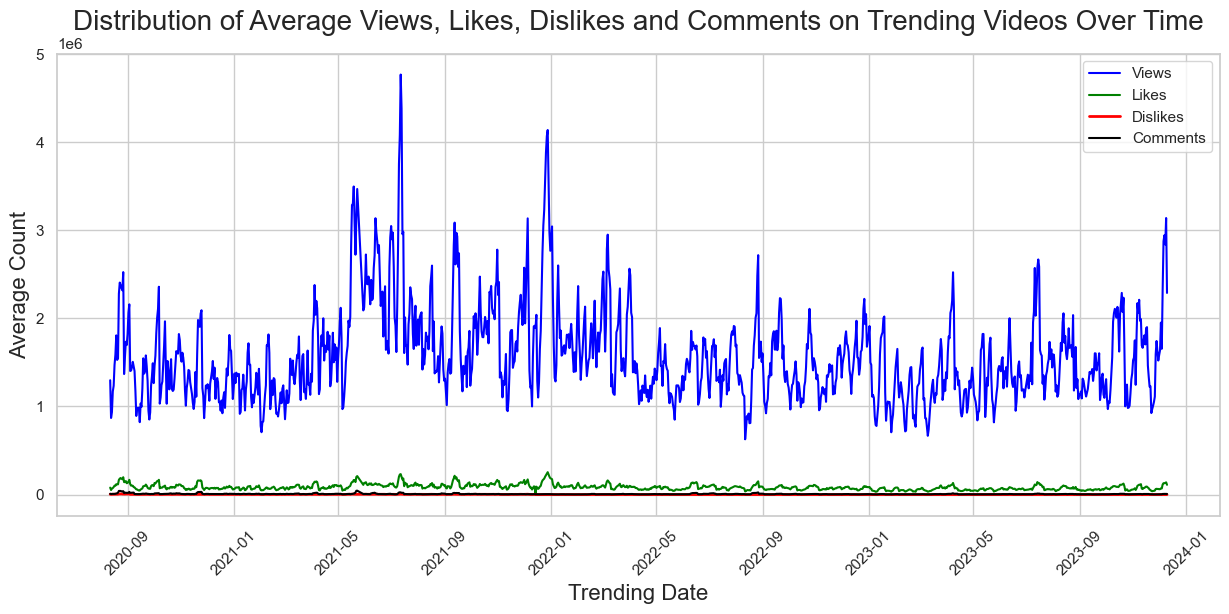

In [54]:
# Views, Likes, Dislikes and Comments over time

df_copy['view_count'] = pd.to_numeric(df_copy['view_count'], errors='coerce')

sns.set(style="whitegrid")
plt.figure(figsize=(15, 6))
sns.lineplot(x='trending_date', y='view_count', data=df_copy, estimator='mean', ci=None, label='Views', color='blue')
sns.lineplot(x='trending_date', y='likes', data=df_copy, estimator='mean', ci=None, label='Likes', color='green')
sns.lineplot(x='trending_date', y='dislikes', data=df_copy, estimator='mean', ci=None, label='Dislikes', color='red', linewidth=2)
sns.lineplot(x='trending_date', y='comment_count', data=df_copy, estimator='mean', ci=None, label='Comments', color='black')

plt.xlabel('Trending Date', fontsize=16)
plt.ylabel('Average Count', fontsize=16)
plt.title('Distribution of Average Views, Likes, Dislikes and Comments on Trending Videos Over Time', fontsize=20)
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [55]:
columns_to_analyze = ['likes', 'dislikes', 'view_count','comment_count']
average_by_date = df_copy.groupby('trending_date')[columns_to_analyze].mean().mean()
for column in columns_to_analyze:
    print(f'Overall Average {column}: {average_by_date[column]:.2f}')

Overall Average likes: 84014.88
Overall Average dislikes: 932.68
Overall Average view_count: 1568950.25
Overall Average comment_count: 6355.18


In [56]:
# average sum of view count per day

df_copy.groupby('trending_date')['view_count'].sum().mean()

321934797.46237457

C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\841768484.py:7: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='trending_date', y='view_count', data=selected_month_data, estimator='mean', ci=None)


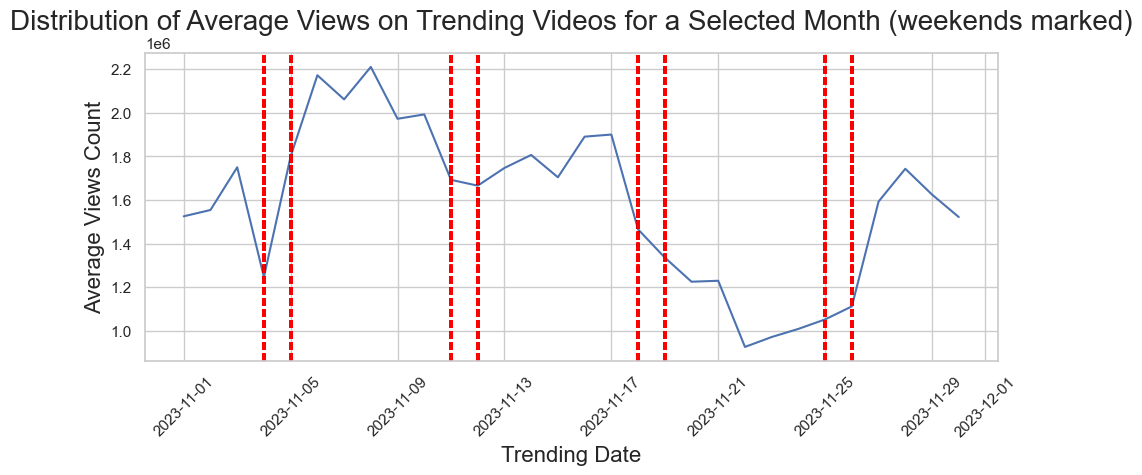

In [57]:
# Distribution of Average Views on Trending Videos for a Selected Month

selected_month_data = df_copy[(df_copy['trending_date'] >= '2023-11-01') & (df_copy['trending_date'] <= '2023-11-30')]

sns.set(style="whitegrid")
plt.figure(figsize=(11, 4))
sns.lineplot(x='trending_date', y='view_count', data=selected_month_data, estimator='mean', ci=None)
plt.xlabel('Trending Date', fontsize=16)
plt.ylabel('Average Views Count', fontsize=16)
plt.title('Distribution of Average Views on Trending Videos for a Selected Month (weekends marked)', fontsize=20)
plt.xticks(rotation=45)
weekends = pd.to_datetime(selected_month_data['trending_date']).dt.dayofweek >= 5
for i, (date, is_weekend) in enumerate(zip(selected_month_data['trending_date'], weekends)):
    if is_weekend:
        plt.axvline(x=date, color='red', linestyle='--', alpha=0.5)
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\1784779123.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='trending_date', y='view_count', data=selected_month_data, estimator='mean', ci=None)


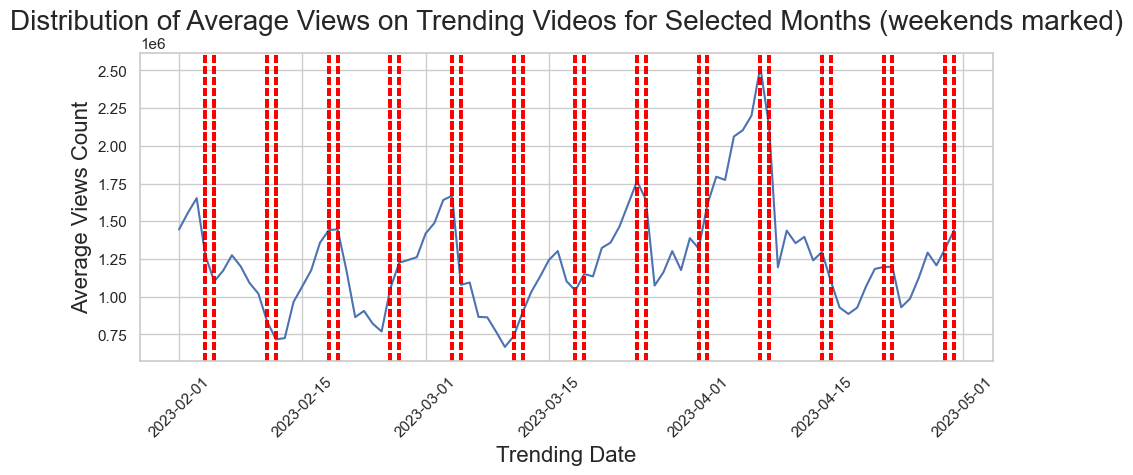

In [58]:
selected_month_data = df_copy[(df_copy['trending_date'] >= '2023-2-01') & (df_copy['trending_date'] <= '2023-4-30')]

sns.set(style="whitegrid")
plt.figure(figsize=(11, 4))
sns.lineplot(x='trending_date', y='view_count', data=selected_month_data, estimator='mean', ci=None)
plt.xlabel('Trending Date', fontsize=16)
plt.ylabel('Average Views Count', fontsize=16)
plt.title('Distribution of Average Views on Trending Videos for Selected Months (weekends marked)', fontsize=20)
plt.xticks(rotation=45)
weekends = pd.to_datetime(selected_month_data['trending_date']).dt.dayofweek >= 5
for i, (date, is_weekend) in enumerate(zip(selected_month_data['trending_date'], weekends)):
    if is_weekend:
        plt.axvline(x=date, color='red', linestyle='--', alpha=0.5)
plt.show()

<b>Typically, YouTube Deutschland garners around 322 million views daily from its trending videos. This figure remains relatively stable, with occasional fluctuations. Interestingly, the view count tends to stay quite close to the average, and there is no noticeable trend linked to weekends. This goes against my assumption that people might prefer other forms of entertainment over watching YouTube during weekends.</b>



C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\2863514981.py:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='day_of_week', y='view_count', data=df_copy, ci=None, estimator='mean', palette='bright')


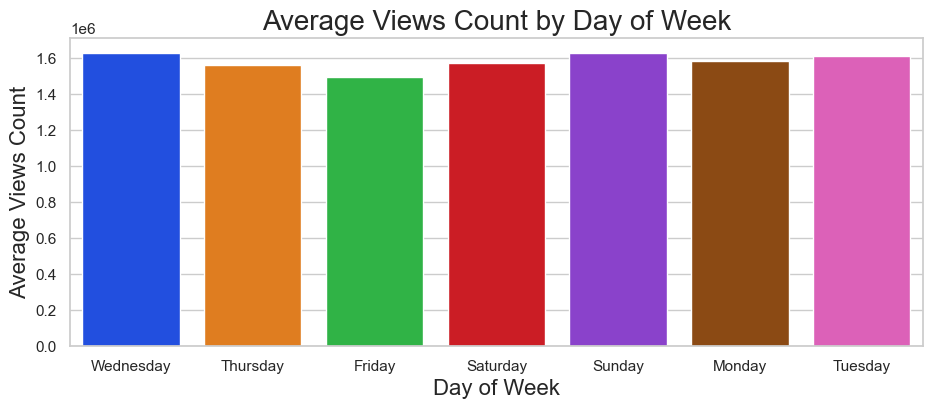

In [59]:
# Average Views Count by Day of Week

df_copy['trending_date'] = pd.to_datetime(df_copy['trending_date'], format='%y.%d.%m')
df_copy['day_of_week'] = df_copy['trending_date'].dt.day_name()

sns.set(style="whitegrid")
plt.figure(figsize=(11, 4))
sns.barplot(x='day_of_week', y='view_count', data=df_copy, ci=None, estimator='mean', palette='bright')
plt.xlabel('Day of Week', fontsize=16)
plt.ylabel('Average Views Count', fontsize=16)
plt.title('Average Views Count by Day of Week', fontsize=20)
plt.show()

In [60]:
df_copy['trending_date'] = pd.to_datetime(df_copy['trending_date'], format='%y.%d.%m')
df_copy['day_of_week'] = df_copy['trending_date'].dt.day_name()

average_views_by_day = df_copy.groupby('day_of_week')['view_count'].mean().reset_index()
average_views_by_day['view_count'] = average_views_by_day['view_count'].apply(lambda x: round(x, 2))
average_views_by_day_sorted = average_views_by_day.sort_values(by='view_count', ascending=False)
average_views_by_day_sorted = average_views_by_day_sorted.reset_index(drop=True)
display(average_views_by_day_sorted)

day_of_week  view_count
0      Sunday  1628359.81
1   Wednesday  1627426.42
2     Tuesday  1612704.18
3      Monday  1581869.87
4    Saturday  1573730.52
5    Thursday  1559434.64
6      Friday  1493404.92

In [61]:
# how many days the videos were trending

video_id_counts = df_copy['video_id'].value_counts()
result_df = pd.DataFrame({'video_id': video_id_counts.index, 'trending_days': video_id_counts.values})
video_count = result_df.groupby('trending_days').size().reset_index(name='video_count')
video_count = video_count.sort_values(by='video_count', ascending=False)
video_count = video_count.reset_index(drop=True)
print(video_count)

    trending_days  video_count
0               5        13982
1               4        13340
2               6         8683
3               3         7015
4               7         3895
5               2         1992
6               8         1068
7               1          861
8               9          332
9              10          164
10             11           97
11             12           38
12             13            8
13             14            1


In [62]:
# longest trending videos (14 and 13 days)

selected_video_ids = result_df.loc[result_df['trending_days'].isin([13, 14]), 'video_id']
selected_videos = df_copy[df_copy['video_id'].isin(selected_video_ids)]
selected_unique_videos = selected_videos.drop_duplicates(subset='video_id')
selected_unique_videos

trending_date     video_id  \
59345  2021-06-07 00:00:00+00:00  nRzdlInfomM   
60145  2021-06-09 00:00:00+00:00  rKRdLsdZMBM   
60745  2021-06-11 00:00:00+00:00  ZeXNf88HnAo   
60747  2021-06-11 00:00:00+00:00  T6n7lZirQkA   
60946  2021-06-11 00:00:00+00:00  x2kIOuanM4M   
60947  2021-06-11 00:00:00+00:00  unvqZvD7gMU   
60948  2021-06-11 00:00:00+00:00  T6tYsQvRAmU   
172543 2022-12-19 00:00:00+00:00  4qQF7dUlRT4   
172549 2022-12-19 00:00:00+00:00  27aDXstZ4Yw   

                                                    title  \
59345   Wir sind Europameister! Deutschland - Portugal...   
60145                                ICH HABE VERSCHLAFEN   
60745                   Philipp Mickenbecker ✝ 09.06.2021   
60747                  Guess the sound challenge🎵 #shorts   
60946   KOLLEGAH - ROTLICHTSONATE (ZHT5 Intro) Officia...   
60947   PA Sports x Kianush x Jamule - Shawty (prod. b...   
60948            AZET - FREIGANG (prod. by Lucry & Suena)   
172543  Argentinien - Frankreich, Highlights mit Live-...   
172549  Unglaublich selten: Legostein aus 14 Karat Gol...   

                                            title_cleaned  title_length  \
59345         deutschland portugal highlights u em finale            82   
60145                                         verschlafen            20   
60745                                philipp mickenbecker            33   
60747                                         guess sound            34   
60946           kollegah rotlichtsonate official 5k video            56   
60947           pa sports x kianush x jamule shawty aside            80   
60948                                 azet freigang lucry            40   
172543   argentinien highlights fifa wm finale magenta tv            91   
172549  unglaublich legostein karat gold tausende euro...            93   

                    published_at  category_id     category_name  \
59345  2021-06-06 22:29:09+00:00           17            Sports   
60145  2021-06-08 16:16:05+00:00           24     Entertainment   
60745  2021-06-10 16:57:41+00:00            1  Film & Animation   
60747  2021-06-07 04:55:00+00:00           23            Comedy   
60946  2021-06-10 22:48:30+00:00           24     Entertainment   
60947  2021-06-10 22:00:10+00:00           10             Music   
60948  2021-06-10 22:00:10+00:00           10             Music   
172543 2022-12-18 18:03:54+00:00           17            Sports   
172549 2022-12-18 16:00:01+00:00           24     Entertainment   

             channel_title                channel_id  ...  \
59345                  DFB  UCfMo0xj-sbdzHuzxvKdu1hw  ...   
60145      unsympathischTV  UC-4Tzd5lIRU7lcv7_5OO01Q  ...   
60745            Life Lion  UCHTvyKiIWD-4iyD6udldjrg  ...   
60747         Tsuriki Show  UCymK_3BWUcoYVVf5D_GmACQ  ...   
60946   ALPHA MUSIC EMPIRE  UCzmO7GegLke-jb5uZSQ9_HA  ...   
60947         LifeisPainTv  UCAbiUl42boUt6vUL019r9Bw  ...   
60948              KMNGANG  UCDLPHv0SrvyUzct8UYQ9R_g  ...   
172543       MAGENTA SPORT  UChr7ZXDFiPOEl543HM4Aj8g  ...   
172549     Bares für Rares  UC53bIpnef1pwAx69ERmmOLA  ...   

                                                     tags  number_of_tags  \
59345   [dfb, dfb tv, deutscher fußball-bund, fußball,...              18   
60145                         [unsympathischtv, beichten]               2   
60745   [life lion, real life guys, philipp mickenbeck...              12   
60747      [tsuriki show, vovanya, vova, anya, challenge]               5   
60946                                            [[none]]               1   
60947   [pa sports jamule kianush shawty, pa sports, j...              25   
60948                                            [[none]]               1   
172543  [magenta, tv, sport, fussball, wm, fifa, 2022,...              25   
172549  [bares für rares, bares für rares neuste folge...              17   

                                              description  description_length  \
59345   Deutschland ist U 21-Eur

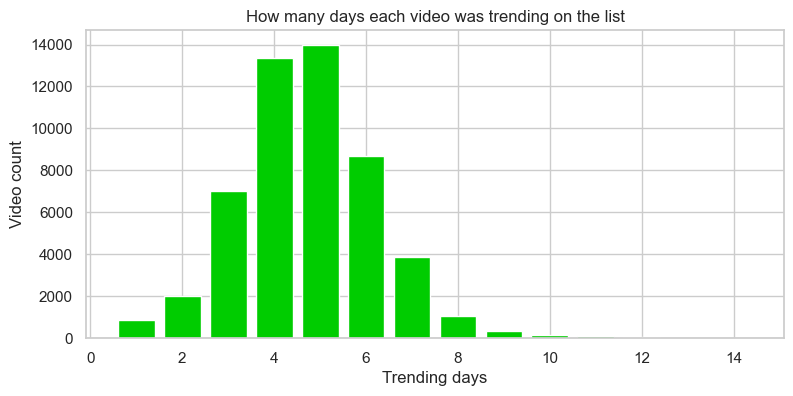

In [63]:
plt.figure(figsize=(9, 4))
plt.bar(video_count['trending_days'], video_count['video_count'], color='#00CC00')
plt.xlabel('Trending days')
plt.ylabel('Video count')
plt.title('How many days each video was trending on the list')
plt.show()

 <b>Observing this chart, it becomes evident that the predominant duration for videos to remain in the limelight falls within the 2-8 day range, implying a tendency for short-lived popularity on the platform. The peak occurs at 5 days, signifying that a substantial number of videos enjoy a brief stint in the trending spotlight.</b>

<b>The controversy index, calculated through metrics like comment rate, dislike rate, and dislike ratio, can provide insights into the level of debate and engagement a piece of content generates. Monitoring this index can help content creators understand audience reactions, optimize content strategies, and gauge the impact of controversial elements.</b>

In [64]:
df_copy['comment_rate'] = df_copy['comment_count'] / df_copy['view_count']
df_copy['dislike_rate'] =  df_copy ['dislikes'] / df_copy['view_count']
df_copy['dislike_ratio'] = df_copy['dislikes'] / (df_copy['dislikes'] + df_copy['likes'])

In [65]:
df_copy = df_copy.replace([np.nan,np.inf,-np.inf],0)

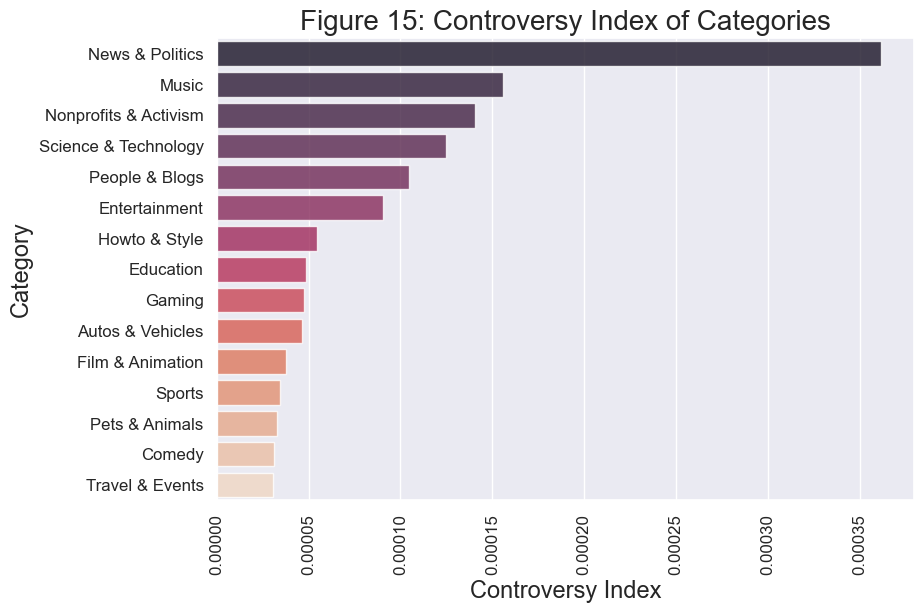

In [66]:
# finding the controversy index for each category
df_copy['controversy_index'] = df_copy['comment_rate'] * df_copy['dislike_ratio']
v_pcd, l_pcd = [], []

for category_name in df_copy['category_name'].unique():
    l_pcd.append(category_name)
    pcd = list(df_copy[df_copy['category_name'] == category_name]['controversy_index'])
    if len(pcd) > 0:
        v_pcd.append(np.mean(pcd))
    else:
        v_pcd.append(0)

# sorting categories from the largest to the smallest Controversy Index value
sorted_indices = np.argsort(v_pcd)[::-1]
v_pcd_sorted = [v_pcd[i] for i in sorted_indices]
l_pcd_sorted = [l_pcd[i] for i in sorted_indices]

sns.set_style("darkgrid")
sns.set(font_scale=1.1)

# graph for each category
fig = plt.figure(figsize=(9,6))
plt.xticks(rotation=90)
sns.barplot(x=v_pcd_sorted, y=l_pcd_sorted, alpha=0.8, palette="rocket")
plt.xlabel('Controversy Index', fontsize=17)
plt.ylabel('Category', fontsize=17)
plt.title('Figure 15: Controversy Index of Categories', fontsize=20)
plt.show()

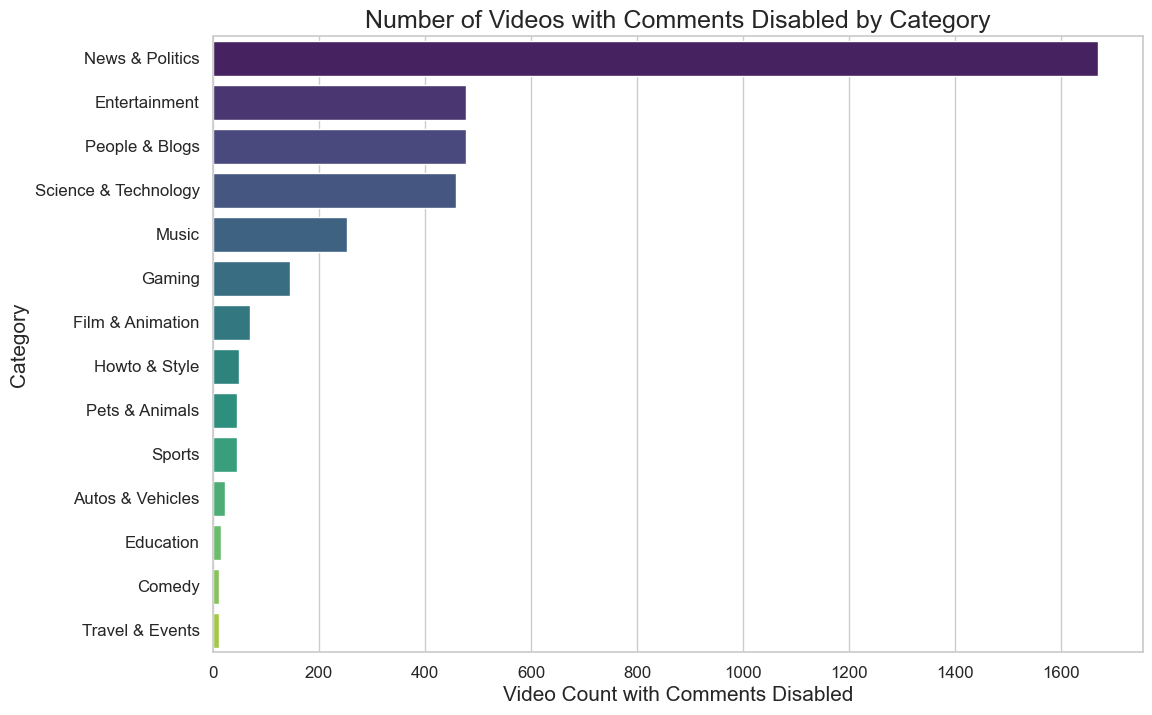

In [67]:
# Number of Videos with Comments Disabled by Category

palette = sns.color_palette("viridis", n_colors=len(df_copy['category_name'].unique()))
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

disabled_comments_df = df_copy[df_copy['comments_disabled'] == True]

sorted_categories = disabled_comments_df['category_name'].value_counts().index
sns.countplot(y='category_name', data=disabled_comments_df, order=sorted_categories, palette=palette)
plt.xlabel('Video Count with Comments Disabled', fontsize=15)
plt.ylabel('Category', fontsize=15)
plt.title('Number of Videos with Comments Disabled by Category', fontsize=18)
plt.show()

<b>In this graphs we can see that The News & Politics has the highest index, which suggests that its content often generates strong reactions. This category and also Entertainment and Science & Technology are among the categories with comments disabled, which may indicate a need for moderation or the controversial nature of the content.</b>

# ML - video views predictions

In [68]:
data_cleaned = data.copy()

In [69]:
data_cleaned.head(3)

trending_date     video_id  \
0 2020-08-12 00:00:00+00:00  KJi2qg5F-9E   
1 2020-08-12 00:00:00+00:00  K0vYnOn7wZI   
2 2020-08-12 00:00:00+00:00  2bbn9b79LRc   

                                               title  \
0                     Bonez MC - HOLLYWOOD (Snippet)   
1  Nik hat heftige Probleme in Köln! 😱😫 #1925 | K...   
2  Camper Tour 2020 - ROADTRIP durch Österreich |...   

                                       title_cleaned  title_length  \
0                                 bonez mc hollywood            30   
1                          nik heftige probleme köln            55   
2  camper tour roadtrip österreich episode anajoh...            70   

               published_at  category_id  category_name channel_title  \
0 2020-08-11 18:00:03+00:00           10          Music      CrhymeTV   
1 2020-08-11 17:00:09+00:00           24  Entertainment    Köln 50667   
2 2020-08-11 18:00:00+00:00           24  Entertainment    AnaJohnson   

                 channel_id  ...  likes  dislikes  comment_count  \
0  UCGh8tmH9x9njaI2mXfh2fyg  ...  69319       970           3311   
1  UCnrvUg5MJWPDSrv_voT7AqA  ...  13637       435            866   
2  UCBt8RY61tvanrhkzeZdNICw  ...   9480       144            364   

                                   thumbnail_link comments_disabled  \
0  https://i.ytimg.com/vi/KJi2qg5F-9E/default.jpg             False   
1  https://i.ytimg.com/vi/K0vYnOn7wZI/default.jpg             False   
2  https://i.ytimg.com/vi/2bbn9b79LRc/default.jpg             False   

   ratings_disabled                                               tags  \
0             False  [187, 187 strassenbande, bonez mc, raf camora,...   
1             False  [köln, 50667, rtl2, rtl, serie, k50667, ganze ...   
2             False  [camper tour, camper tour deutsch, camper tour...   

  number_of_tags                                        description  \
0             34  Hollywood Fanbox vorbestellen ► http://bonezmc...   
1             29  Toni gerät in Panik, als plötzlich ein Unbekan...   
2             23  Mehr von unserem Trip quer durch Deutschland, ...   

  description_length  
0                473  
1               1544  
2               1323  

[3 rows x 21 columns]

In [70]:
data_cleaned = data.drop(['trending_date', 'published_at', 'video_id', 'title', 'title_cleaned',
       'category_name', 'channel_title', 'channel_id', 'thumbnail_link',
       'tags', 'description'], axis=1)

In [71]:
data_cleaned.duplicated().sum()

153

In [72]:
# dropping duplicates

data_cleaned = data_cleaned.drop_duplicates()

<b>Handling unbalanced data</b>

C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\1124975715.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(data_cleaned['likes'],kde=True, ax=ax[0,0])
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\1124975715.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(np.log1p(data_cleaned

Text(0.5, 0, '')

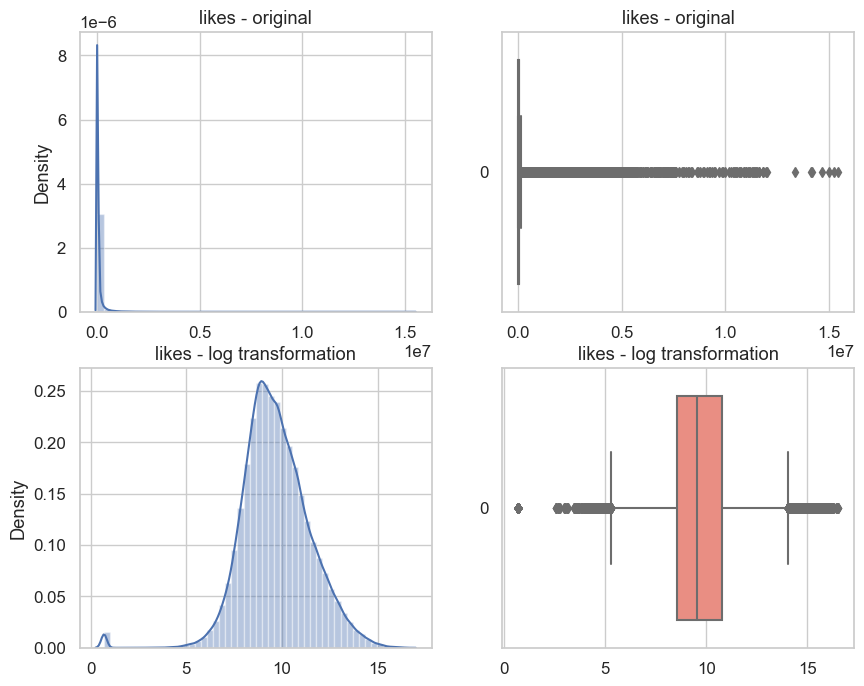

In [73]:
f,ax = plt.subplots(2,2,figsize=(10,8))
g = sns.distplot(data_cleaned['likes'],kde=True, ax=ax[0,0])
ax[0,0].set_title('likes - original')
ax[0,0].set_xlabel('')

g = sns.boxplot(data_cleaned['likes'],color='salmon',orient='h', ax=ax[0,1])
ax[0,1].set_title('likes - original')
ax[0,1].set_xlabel('')

g = sns.distplot(np.log1p(data_cleaned['likes']+1),kde=True, ax=ax[1,0])
ax[1,0].set_title('likes - log transformation')
ax[1,0].set_xlabel('')

g = sns.boxplot(np.log1p(data_cleaned['likes']+1),color='salmon',orient='h', ax=ax[1,1])
ax[1,1].set_title('likes - log transformation')
ax[1,1].set_xlabel('')

C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\752512805.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(data_cleaned['dislikes'],kde=True, ax=ax[0,0])
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\752512805.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(np.log1p(data_cleane

Text(0.5, 0, '')

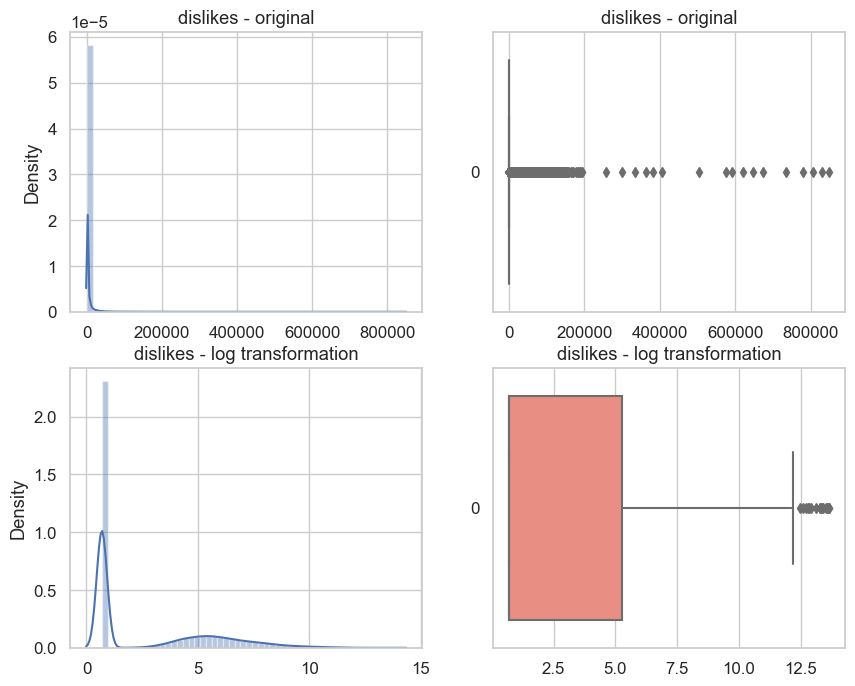

In [74]:
f,ax = plt.subplots(2,2,figsize=(10,8))
g = sns.distplot(data_cleaned['dislikes'],kde=True, ax=ax[0,0])
ax[0,0].set_title('dislikes - original')
ax[0,0].set_xlabel('')

g = sns.boxplot(data_cleaned['dislikes'],color='salmon',orient='h', ax=ax[0,1])
ax[0,1].set_title('dislikes - original')
ax[0,1].set_xlabel('')

g = sns.distplot(np.log1p(data_cleaned['dislikes']+1),kde=True, ax=ax[1,0])
ax[1,0].set_title('dislikes - log transformation')
ax[1,0].set_xlabel('')

g = sns.boxplot(np.log1p(data_cleaned['dislikes']+1),color='salmon',orient='h', ax=ax[1,1])
ax[1,1].set_title('dislikes - log transformation')
ax[1,1].set_xlabel('')

C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\1747028213.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(data_cleaned['comment_count'],kde=True, ax=ax[0,0])
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\1747028213.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(np.log1p(data

Text(0.5, 0, '')

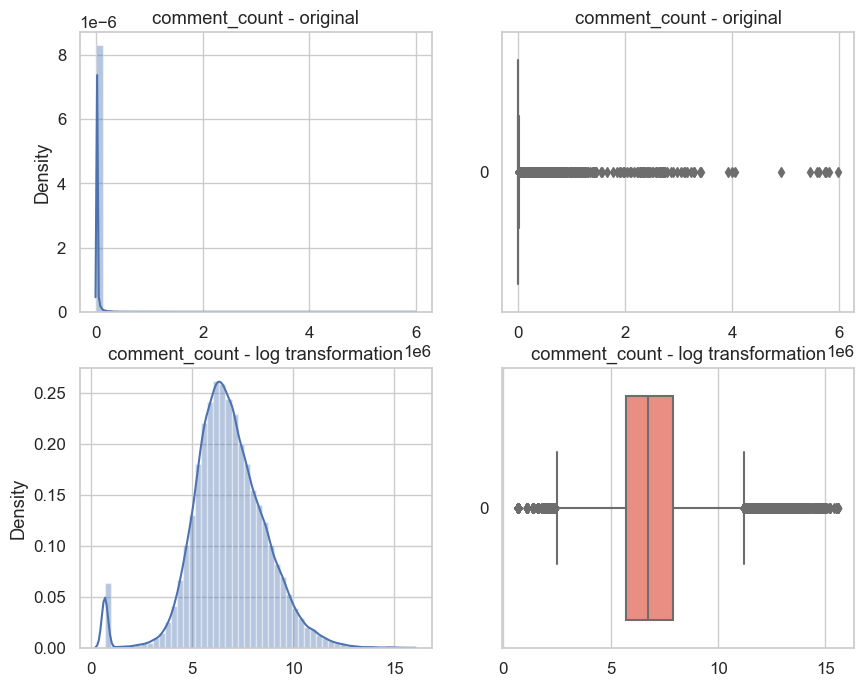

In [75]:
f,ax = plt.subplots(2,2,figsize=(10,8))
g = sns.distplot(data_cleaned['comment_count'],kde=True, ax=ax[0,0])
ax[0,0].set_title('comment_count - original')
ax[0,0].set_xlabel('')

g = sns.boxplot(data_cleaned['comment_count'],color='salmon',orient='h', ax=ax[0,1])
ax[0,1].set_title('comment_count - original')
ax[0,1].set_xlabel('')

g = sns.distplot(np.log1p(data_cleaned['comment_count']+1),kde=True, ax=ax[1,0])
ax[1,0].set_title('comment_count - log transformation')
ax[1,0].set_xlabel('')

g = sns.boxplot(np.log1p(data_cleaned['comment_count']+1),color='salmon',orient='h', ax=ax[1,1])
ax[1,1].set_title('comment_count - log transformation')
ax[1,1].set_xlabel('')

C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\3278126918.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(data_cleaned['description_length'],kde=True, ax=ax[0,0])
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\3278126918.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(np.log1p

Text(0.5, 0, '')

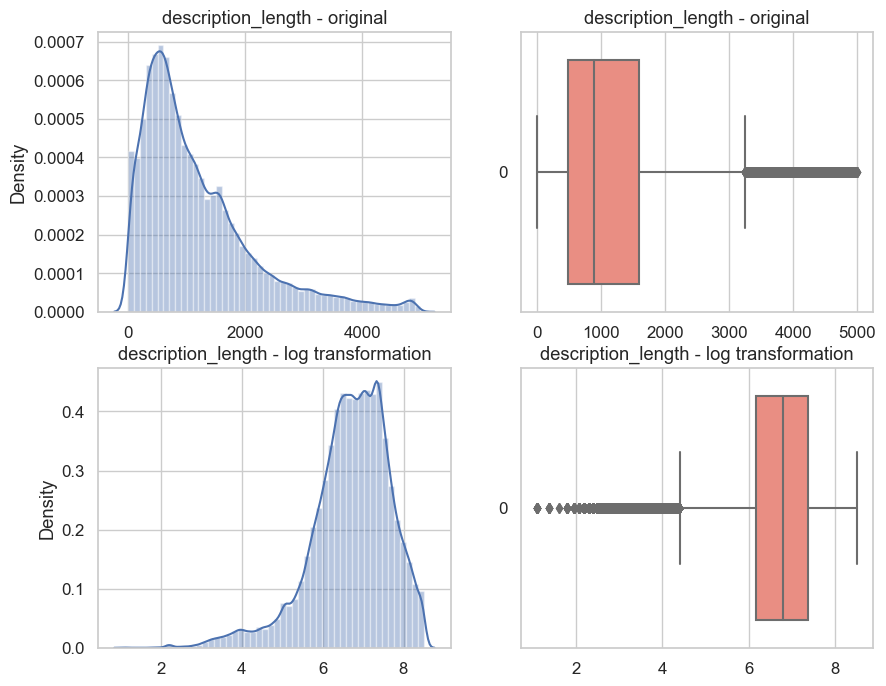

In [76]:
f,ax = plt.subplots(2,2,figsize=(10,8))
g = sns.distplot(data_cleaned['description_length'],kde=True, ax=ax[0,0])
ax[0,0].set_title('description_length - original')
ax[0,0].set_xlabel('')

g = sns.boxplot(data_cleaned['description_length'],color='salmon',orient='h', ax=ax[0,1])
ax[0,1].set_title('description_length - original')
ax[0,1].set_xlabel('')

g = sns.distplot(np.log1p(data_cleaned['description_length']+1),kde=True, ax=ax[1,0])
ax[1,0].set_title('description_length - log transformation')
ax[1,0].set_xlabel('')

g = sns.boxplot(np.log1p(data_cleaned['description_length']+1),color='salmon',orient='h', ax=ax[1,1])
ax[1,1].set_title('description_length - log transformation')
ax[1,1].set_xlabel('')

C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\4062383939.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(data_cleaned['number_of_tags'],kde=True, ax=ax[0,0])
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\4062383939.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(np.log1p(dat

Text(0.5, 0, '')

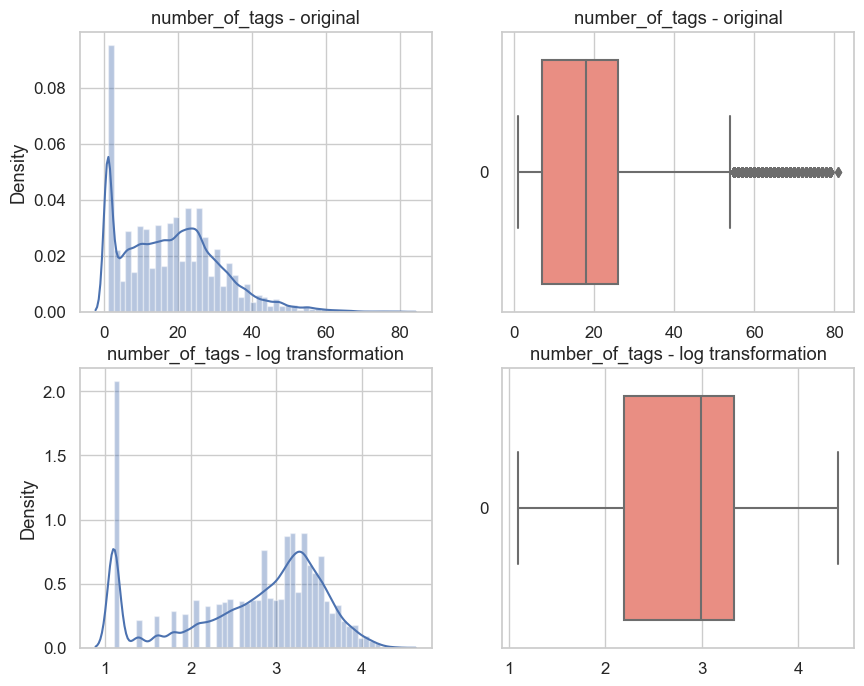

In [77]:
f,ax = plt.subplots(2,2,figsize=(10,8))
g = sns.distplot(data_cleaned['number_of_tags'],kde=True, ax=ax[0,0])
ax[0,0].set_title('number_of_tags - original')
ax[0,0].set_xlabel('')

g = sns.boxplot(data_cleaned['number_of_tags'],color='salmon',orient='h', ax=ax[0,1])
ax[0,1].set_title('number_of_tags - original')
ax[0,1].set_xlabel('')

g = sns.distplot(np.log1p(data_cleaned['number_of_tags']+1),kde=True, ax=ax[1,0])
ax[1,0].set_title('number_of_tags - log transformation')
ax[1,0].set_xlabel('')

g = sns.boxplot(np.log1p(data_cleaned['number_of_tags']+1),color='salmon',orient='h', ax=ax[1,1])
ax[1,1].set_title('number_of_tags - log transformation')
ax[1,1].set_xlabel('')

C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\182146486.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(data_cleaned['view_count'],kde=True, ax=ax[0,0])
C:\Users\Acer\AppData\Local\Temp\ipykernel_7344\182146486.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  g = sns.distplot(np.log1p(data_clea

Text(0.5, 0, '')

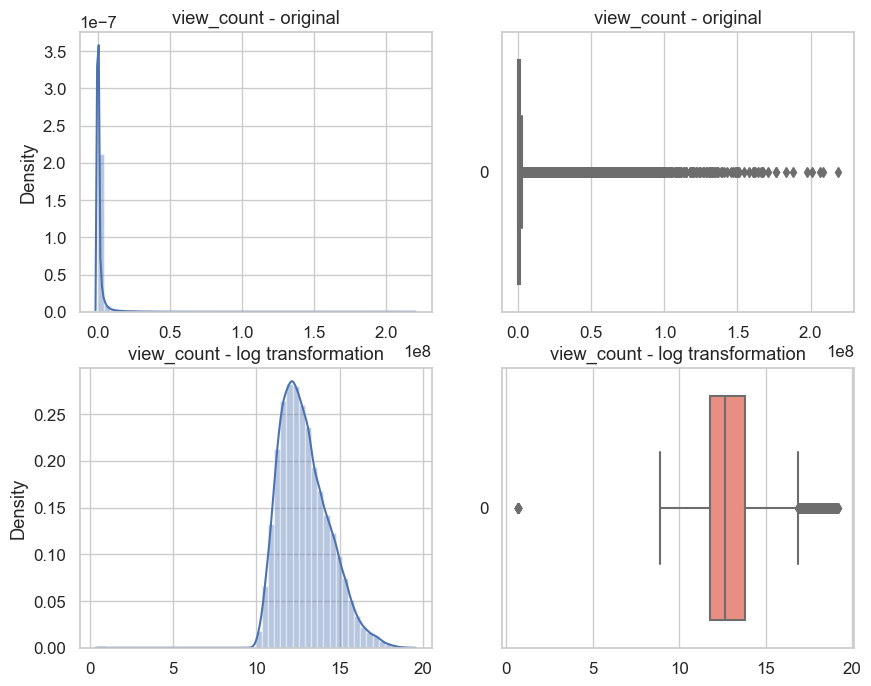

In [78]:
f,ax = plt.subplots(2,2,figsize=(10,8))
g = sns.distplot(data_cleaned['view_count'],kde=True, ax=ax[0,0])
ax[0,0].set_title('view_count - original')
ax[0,0].set_xlabel('')

g = sns.boxplot(data_cleaned['view_count'],color='salmon',orient='h', ax=ax[0,1])
ax[0,1].set_title('view_count - original')
ax[0,1].set_xlabel('')

g = sns.distplot(np.log1p(data_cleaned['view_count']+1),kde=True, ax=ax[1,0])
ax[1,0].set_title('view_count - log transformation')
ax[1,0].set_xlabel('')

g = sns.boxplot(np.log1p(data_cleaned['view_count']+1),color='salmon',orient='h', ax=ax[1,1])
ax[1,1].set_title('view_count - log transformation')
ax[1,1].set_xlabel('')

In [79]:
features = ['view_count', 'likes', 'dislikes', 'comment_count', 'number_of_tags', 'category_id', 'title_length', 'description_length']

df_prepared = data_cleaned.copy()
for var in features:
    df_prepared['log_'+var]= (data_cleaned[var] + 1).apply(np.log)

In [80]:
# normalization 

for var in features:
    df_prepared['std_'+var]= MinMaxScaler().fit_transform(df_prepared[var].values.reshape(len(df_prepared), 1))

In [81]:
data_cleaned.describe()

title_length    category_id    view_count         likes  \
count  243183.000000  243183.000000  2.431830e+05  2.431830e+05   
mean       55.719561      19.138797  1.583109e+06  8.455386e+04   
std        22.079455       6.813791  5.556098e+06  3.372851e+05   
min         1.000000       1.000000  0.000000e+00  0.000000e+00   
25%        39.000000      17.000000  1.299340e+05  5.313000e+03   
50%        53.000000      22.000000  3.183480e+05  1.429500e+04   
75%        71.000000      24.000000  1.006645e+06  4.744450e+04   
max       100.000000      29.000000  2.191105e+08  1.546084e+07   

            dislikes  comment_count  number_of_tags  description_length  
count  243183.000000   2.431830e+05   243183.000000       243183.000000  
mean      967.518075   6.416445e+03       18.265257         1172.274735  
std      7361.819426   6.160698e+04       13.076893          965.426928  
min         0.000000   0.000000e+00        1.000000            1.000000  
25%         0.000000   3.040000e+02        7.000000          482.000000  
50%         0.000000   8.220000e+02       18.000000          891.000000  
75%       196.000000   2.727000e+03       26.000000         1590.000000  
max    848975.000000   5.987755e+06       81.000000         4998.000000

In [82]:
# Split Train & Test

X = df_prepared[['std_category_id','std_likes','std_dislikes','std_comment_count','std_number_of_tags','std_description_length','std_title_length']]
y = df_prepared['std_view_count'] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

In [83]:
# Linear Regression

regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [84]:
pred = regressor.predict(X_test)

In [85]:
np.exp(pred).round()

array([1., 1., 1., ..., 1., 1., 1.])

In [86]:
# evaluation

def eval_regression(model, pred, X_train, y_train, X_test, y_test):
    print("MAE: %.2f" % mean_absolute_error(y_test, pred)) # The MAE
    print("RMSE: %.2f" % mean_squared_error(y_test, pred, squared=False)) # The RMSE
    print('R2 score: %.2f' % r2_score(y_test, pred)) # Explained variance score: 1 is perfect prediction

In [87]:
pred = regressor.predict(X_test)

print('Coefficients: \n', regressor.coef_) # The slope
print('Intercept: \n', regressor.intercept_) # The Intercept

eval_regression(regressor, pred, X_train, y_train, X_test,y_test)

Coefficients: 
 [ 7.60875175e-04  1.04184520e+00  4.29976106e-01 -4.17675196e-01
  4.15635846e-05 -1.04950192e-03  7.60484757e-04]
Intercept: 
 0.0008058427544253436
MAE: 0.00
RMSE: 0.01
R2 score: 0.74


In [88]:
# Decision Tree Model

dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)
pred = dt.predict(X_test)
eval_regression(dt, pred, X_train, y_train, X_test, y_test)

MAE: 0.00
RMSE: 0.01
R2 score: 0.88


In [89]:
# Random Forest Model

rf = RandomForestRegressor(random_state=104)
best_model1 = rf.fit(X_train, y_train)
pred = rf.predict(X_test)
eval_regression(rf, pred, X_train, y_train, X_test, y_test)

MAE: 0.00
RMSE: 0.01
R2 score: 0.95


<b>Conclusion
- Random Forest with MAE 0.00, RMSE 0.01, and R2 of 0.95 is the best model so far
- Decision Tree is the second best model with a slightly smaller R2 value of 0.88</b>